In [1]:
from lxml import etree as ET
from argparse import ArgumentParser
import sys
from os import path
from collections import defaultdict
import matplotlib.pyplot as plt
import random
import numpy as np
import glob

In [2]:
def type_token_ratio(toks, n=None, method="abs"):
    if method == "abs":
        tok_count = len(toks)
        type_count = len(set(toks))
    if method == "samp":
        tok_count = n if n is not None else 50000
        r = 5
        type_counts = [len(set(random.sample(toks, tok_count))) for _ in range(r)]
        type_count = sum(type_counts)/r
    if method == "sttr":
        chunk_size = n if n is not None else 1000
        chunks = len(toks)//1000
        total = 0
        for chunk in range(chunks):
            start = chunk * chunk_size
            end = start + chunk_size
            ttr = type_token_ratio(toks[start:end])
            total += ttr
        return total / chunks
    return type_count / tok_count


In [3]:
def org_files(files):
    orged_files = defaultdict(lambda: defaultdict(list))
    for file in files:
        author = path.basename(path.dirname(path.dirname(file)))
        work = path.basename(path.dirname(file))
        orged_files[author][work].append(file)
    return orged_files

In [4]:
author_dict = {"bernstein": "Bernstein",
               "gramsci": "Gramsci",
               "kautsky": "Kautsky",
               "mao": "Mao",
               "marx_engels": "Marx/Engels",
               "luxemburg": "Luxemburg",
               "thaelmann": "Thälmann",
               "lenin": "Lenin",
               "stalin": "Stalin",
               "trotzki": "Trotzki"}

# Reading in the data

In [5]:
tokens = defaultdict(list)
work_bounds = defaultdict(list)

In [6]:
files = glob.glob("../tei/*/*/*")
orged_files = org_files(files)


In [7]:
ns = {"tei": "http://www.tei-c.org/ns/1.0"}
for author, works in orged_files.items():
    print(f"Working on {author}...")
    for work, files in sorted(works.items(), key= lambda x: x[0]):
        work_bounds[author].append({"work": work, "index":len(tokens[author])})
        for file in files:
            doc = path.basename(file)
            work = path.basename(path.dirname(file))
            author = path.basename(path.dirname(path.dirname(file)))
            with open(file, "rb") as xml_file:
                tree = ET.parse(xml_file)
            root = tree.getroot()
            words = root.findall(".//tei:w", ns)
            for w in words:
                tokens[author].append((w.text.lower(), w.attrib["lemma"]))
print("Done")


Working on mao...
Working on bernstein...
Working on marx_engels...
Working on kautsky...
Working on luxemburg...
Working on gramsci...
Working on thaelmann...
Working on lenin...
Working on stalin...
Working on trotzki...
Done


# Calculating TTR 

In [83]:
ttr_for_all = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

for author, toks in tokens.items():
        for m in ["abs", "samp", "sttr"]:
            ttr = type_token_ratio([t[0] for t in toks], method=m)
            ttr_for_all[author][m] = ttr

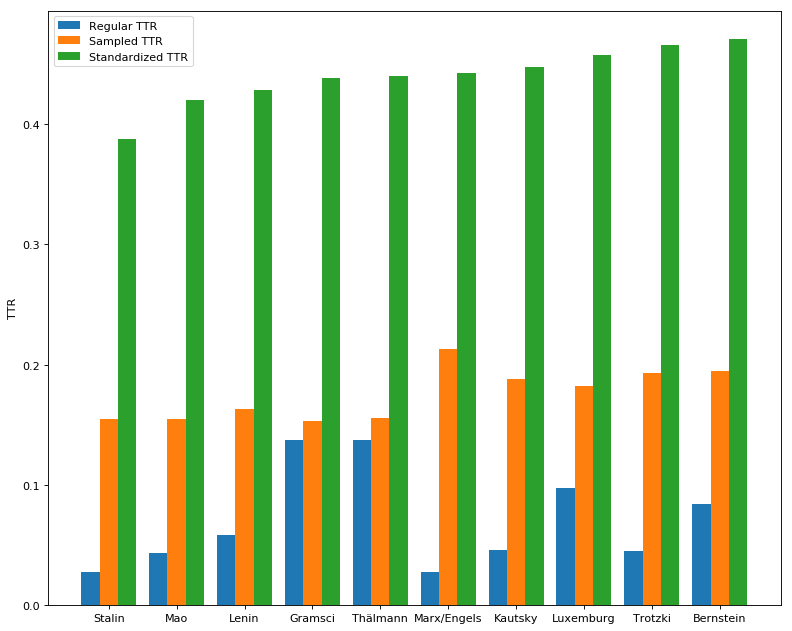

In [84]:
authors = sorted(ttr_for_all.keys(), key= lambda x: ttr_for_all[x]["sttr"])

abs_values = [ttr_for_all[a]["abs"] for a in authors]
samp_values = [ttr_for_all[a]["samp"] for a in authors]
sttr_values = [ttr_for_all[a]["sttr"] for a in authors]


x = np.arange(len(authors))  # the label locations
width = .27  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 8), dpi= 80)
rects1 = ax.bar(x - width, abs_values, width, label='Regular TTR')
rects1 = ax.bar(x, samp_values, width, label='Sampled TTR')
rects3 = ax.bar(x + width, sttr_values, width, label="Standardized TTR")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('TTR')
ax.set_xticks(x)
ax.set_xticklabels([author_dict[a] for a in authors])
ax.legend()


fig.tight_layout()
plt.savefig("figures/ttr.png", format="png")
plt.show()

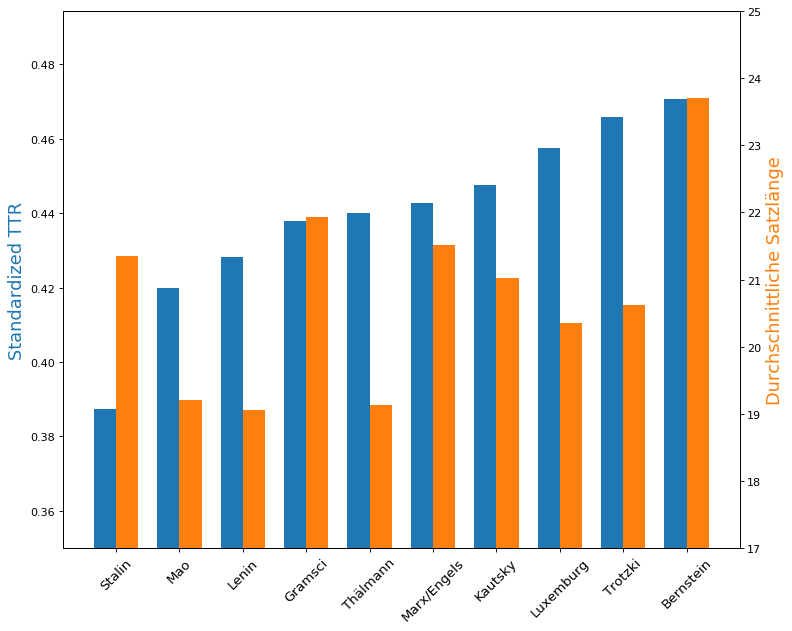

In [85]:
sent_lengths = {"bernstein": 330748/13950, 
                "gramsci": 55129/2514, 
                "kautsky": 1116232/53086,
                "lenin": 367521/19286,
                "luxemburg": 194232/9542,
                "mao": 596408/31045,
                "marx_engels": 5075961/235863,
                "stalin": 1364004/63879,
                "thaelmann": 58897/3079,
                "trotzki": 1151473/55826}



sl_values = [sent_lengths[a] for a in authors]

fig, ax1 = plt.subplots(figsize=(10, 8), dpi= 80)
ax1.set_xticks(x)
ax1.set_xticklabels([author_dict[a] for a in authors], rotation=45, fontsize=12)

color1 = "C0"
color2 = "C1"
width = .35  # the width of the bars


ax1.set_ylabel("Standardized TTR", color=color1, fontsize=16)
ax1.bar(x - width*.5, sttr_values, width, label='Standardized TTR', color=color1)
ax1.set_ylim(bottom=0.35)
ax2 = ax1.twinx()
ax2.set_ylim(bottom=17, top=25)
ax2.set_ylabel("Durchschnittliche Satzlänge", color=color2, fontsize=16)
ax2.bar(x+width*.5, sl_values, width, color=color2, label="Average sentence length")

fig.tight_layout()
plt.savefig("figures/ttr_sl.pdf", format="pdf")
plt.show()

In [205]:
from scipy.stats import spearmanr
indices = [0,3,5,6,7,8]
interest_sttr = [sttr_values[i] for i in indices]
interest_sl = [sl_values[i] for i in indices]

spearmanr(interest_sttr, interest_sl)

SpearmanrResult(correlation=-0.7714285714285715, pvalue=0.07239650145772594)

# Showing term distribution

In [8]:
def find_term(toks, term):
    indices = []
    for i, t in enumerate(toks):
        if t == term:
            indices.append(i)
    return indices

In [9]:
def term_freq(term_locs, total_toks, window_size=10000, step_size=10000):
    values = []
    for i in range(total_toks//step_size):
        start = i * step_size
        end = start + window_size
        matches = len([v for v in term_locs if start <= v < end])
        values.append(matches)
    return values 

In [10]:
terms = ["wert", "ware", "arbeit"]

In [11]:
terms = ["staat", "bürokratie"]

In [12]:
terms = ["dialektik", "widerspruch", "aufhebung"]

In [13]:
terms = ["revolution", "sozialismus", "diktatur"]

In [13]:
all_terms = {"Politische Ökonomie": ["wert", "ware", "klasse"],
             "Philosophie": ["dialektik", "widerspruch", "aufhebung"],
             "Staatstheorie": ["staat", "bürokratie", "diktatur"],
             "Sozialismusverständnis": ["sozialismus", "diktatur", "wertgesetz"],
             "Strategie und Taktik": ["revolution", "bündnis", "reform"]}
term_cats= sorted(all_terms.keys())

## All in One

In [56]:
author = "trotzki"
toks = [t[1].lower() for t in tokens[author]]
terms_locs = {cat: [find_term(toks, t) for t in all_terms[cat]] for cat in term_cats}

In [13]:
window_size = len(toks)//200
step_size = len(toks)//200
values = {cat: [term_freq(tl, len(toks), window_size, step_size) for tl in terms_locs[cat]] for cat in term_cats}

NameError: name 'toks' is not defined

In [16]:
import numpy as np

def mystep(x,y, ax=None, **kwargs):
    x = np.array(x)
    y = np.array(y)
    X = np.c_[x[:-1],x[1:],x[1:]]
    Y = np.c_[y[:-1],y[:-1],np.zeros_like(x[:-1])*np.nan]
    if not ax: ax=plt.gca()
    return ax.plot(X.flatten(), Y.flatten(), **kwargs)

Working on bernstein...
Working on gramsci...
Working on kautsky...
Working on mao...
Working on marx_engels...
Working on luxemburg...
Working on thaelmann...
Working on lenin...
Working on stalin...
Working on trotzki...


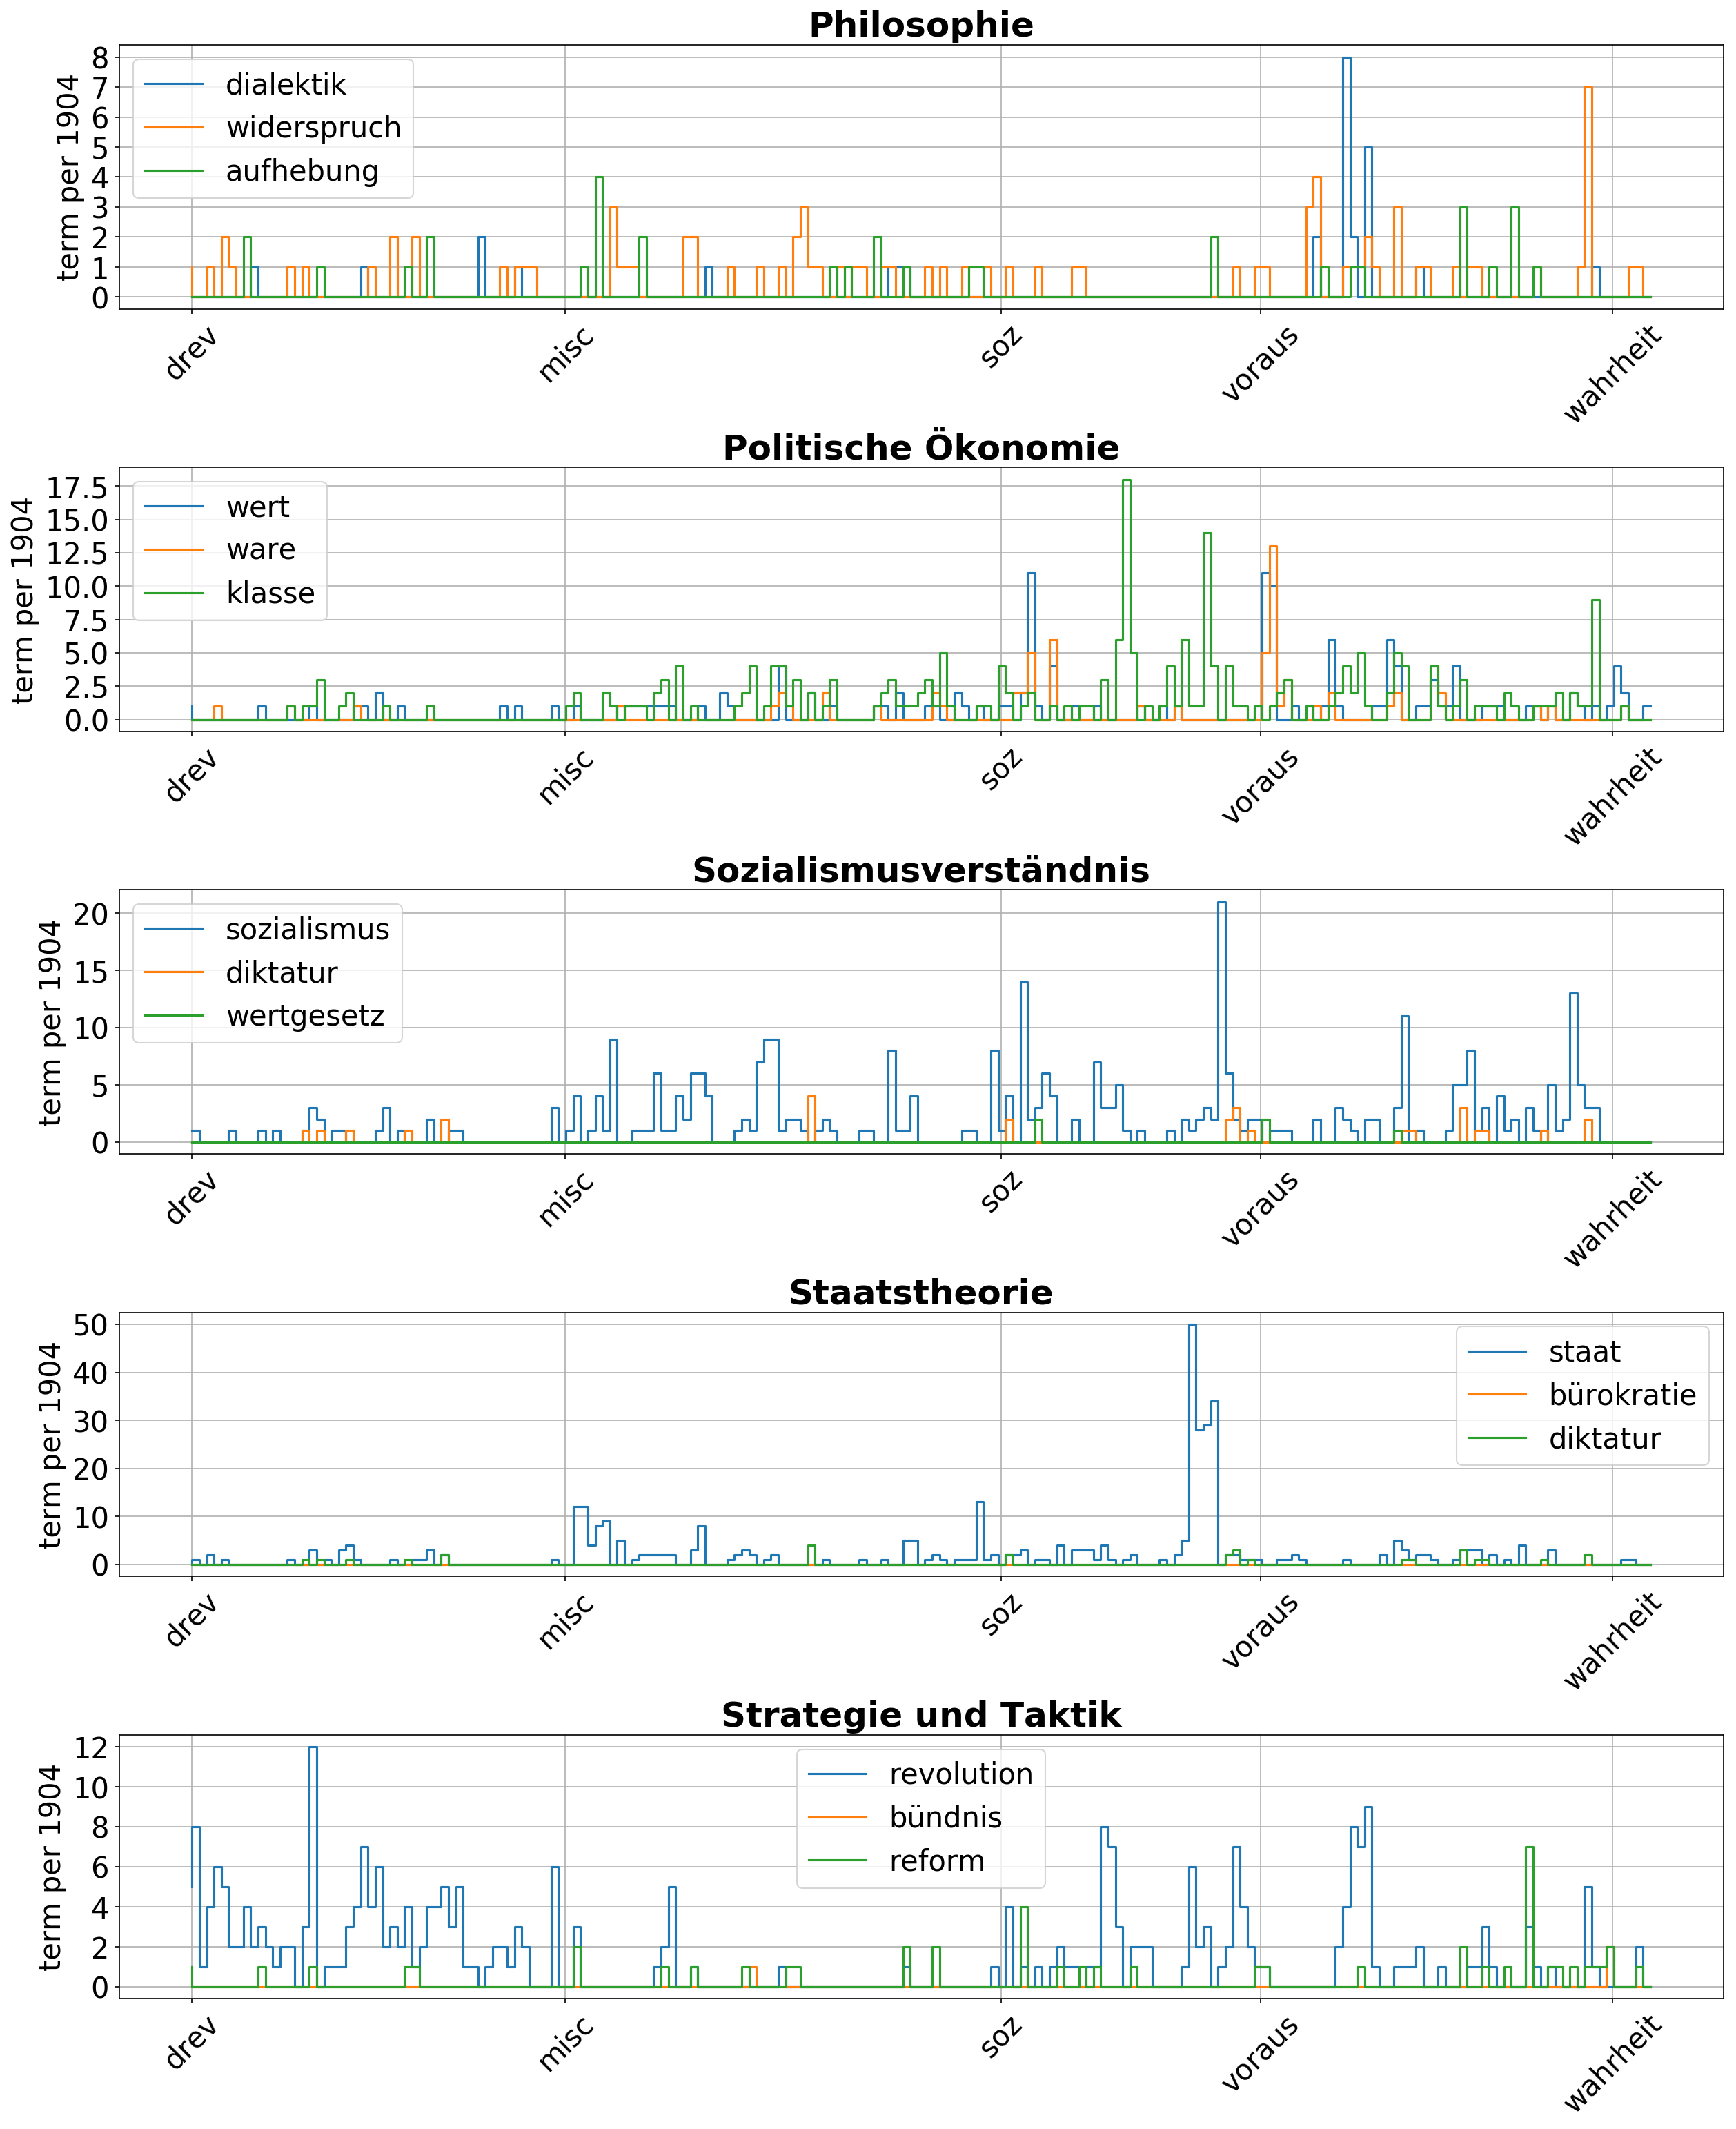

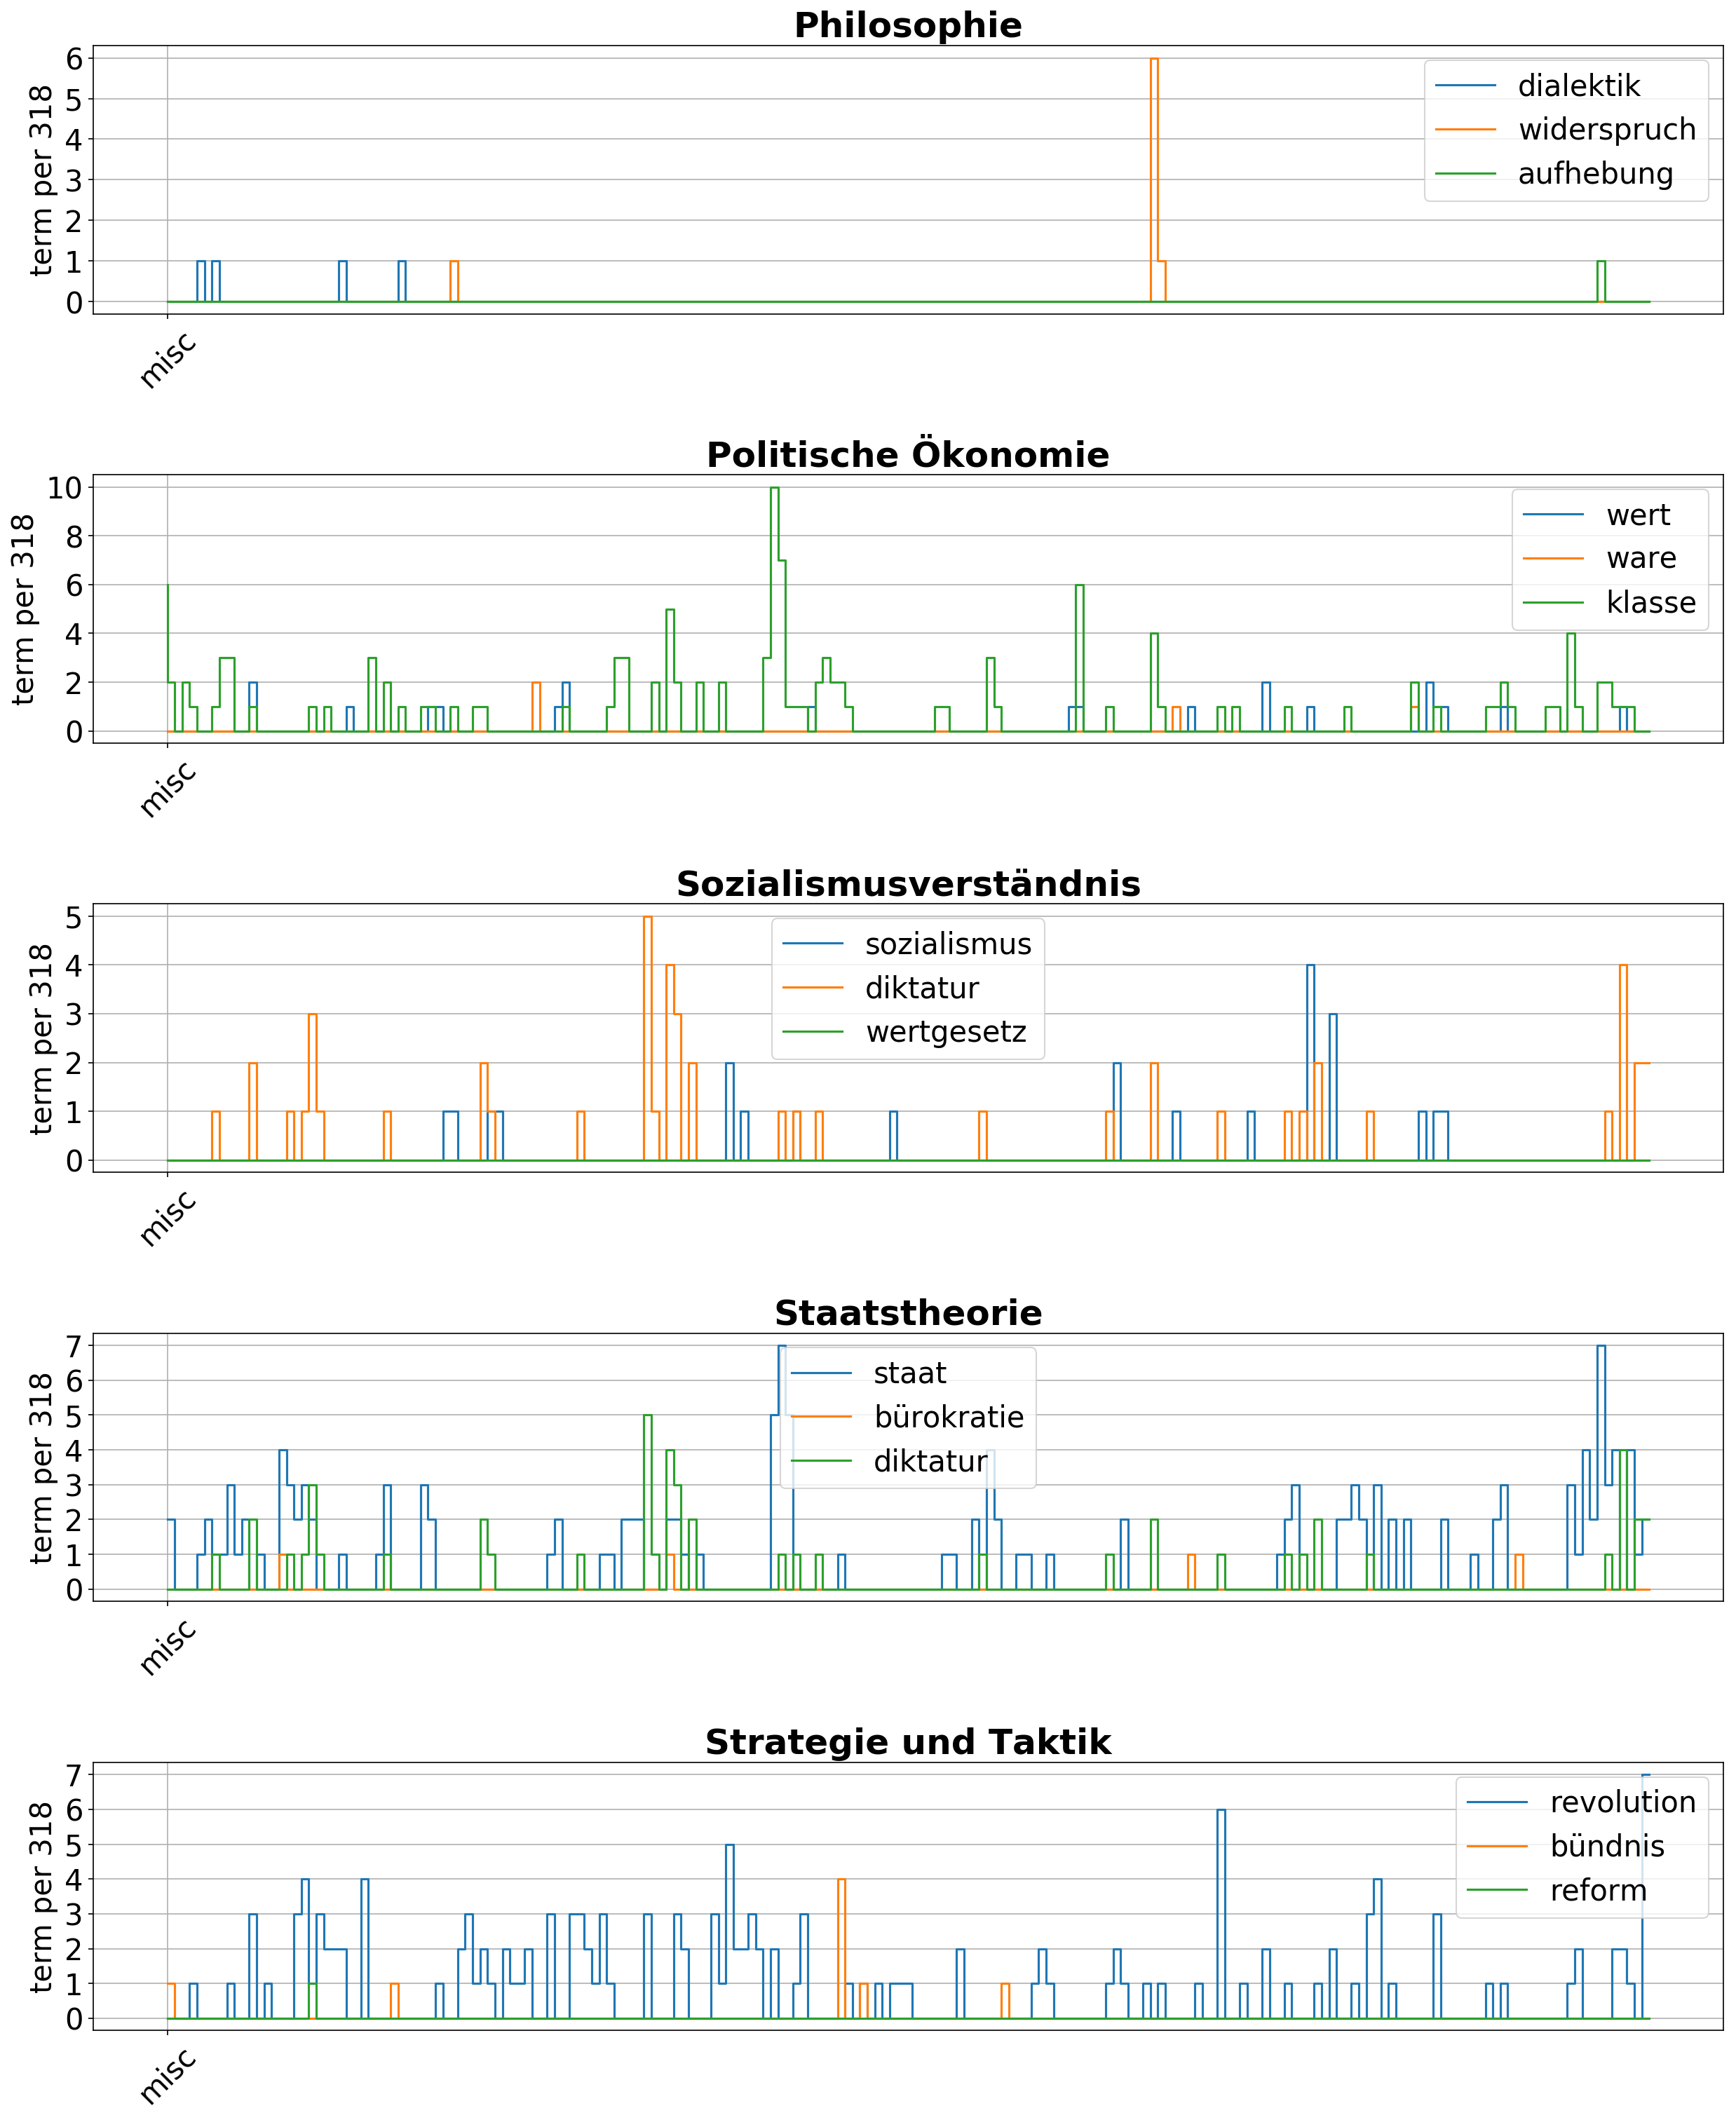

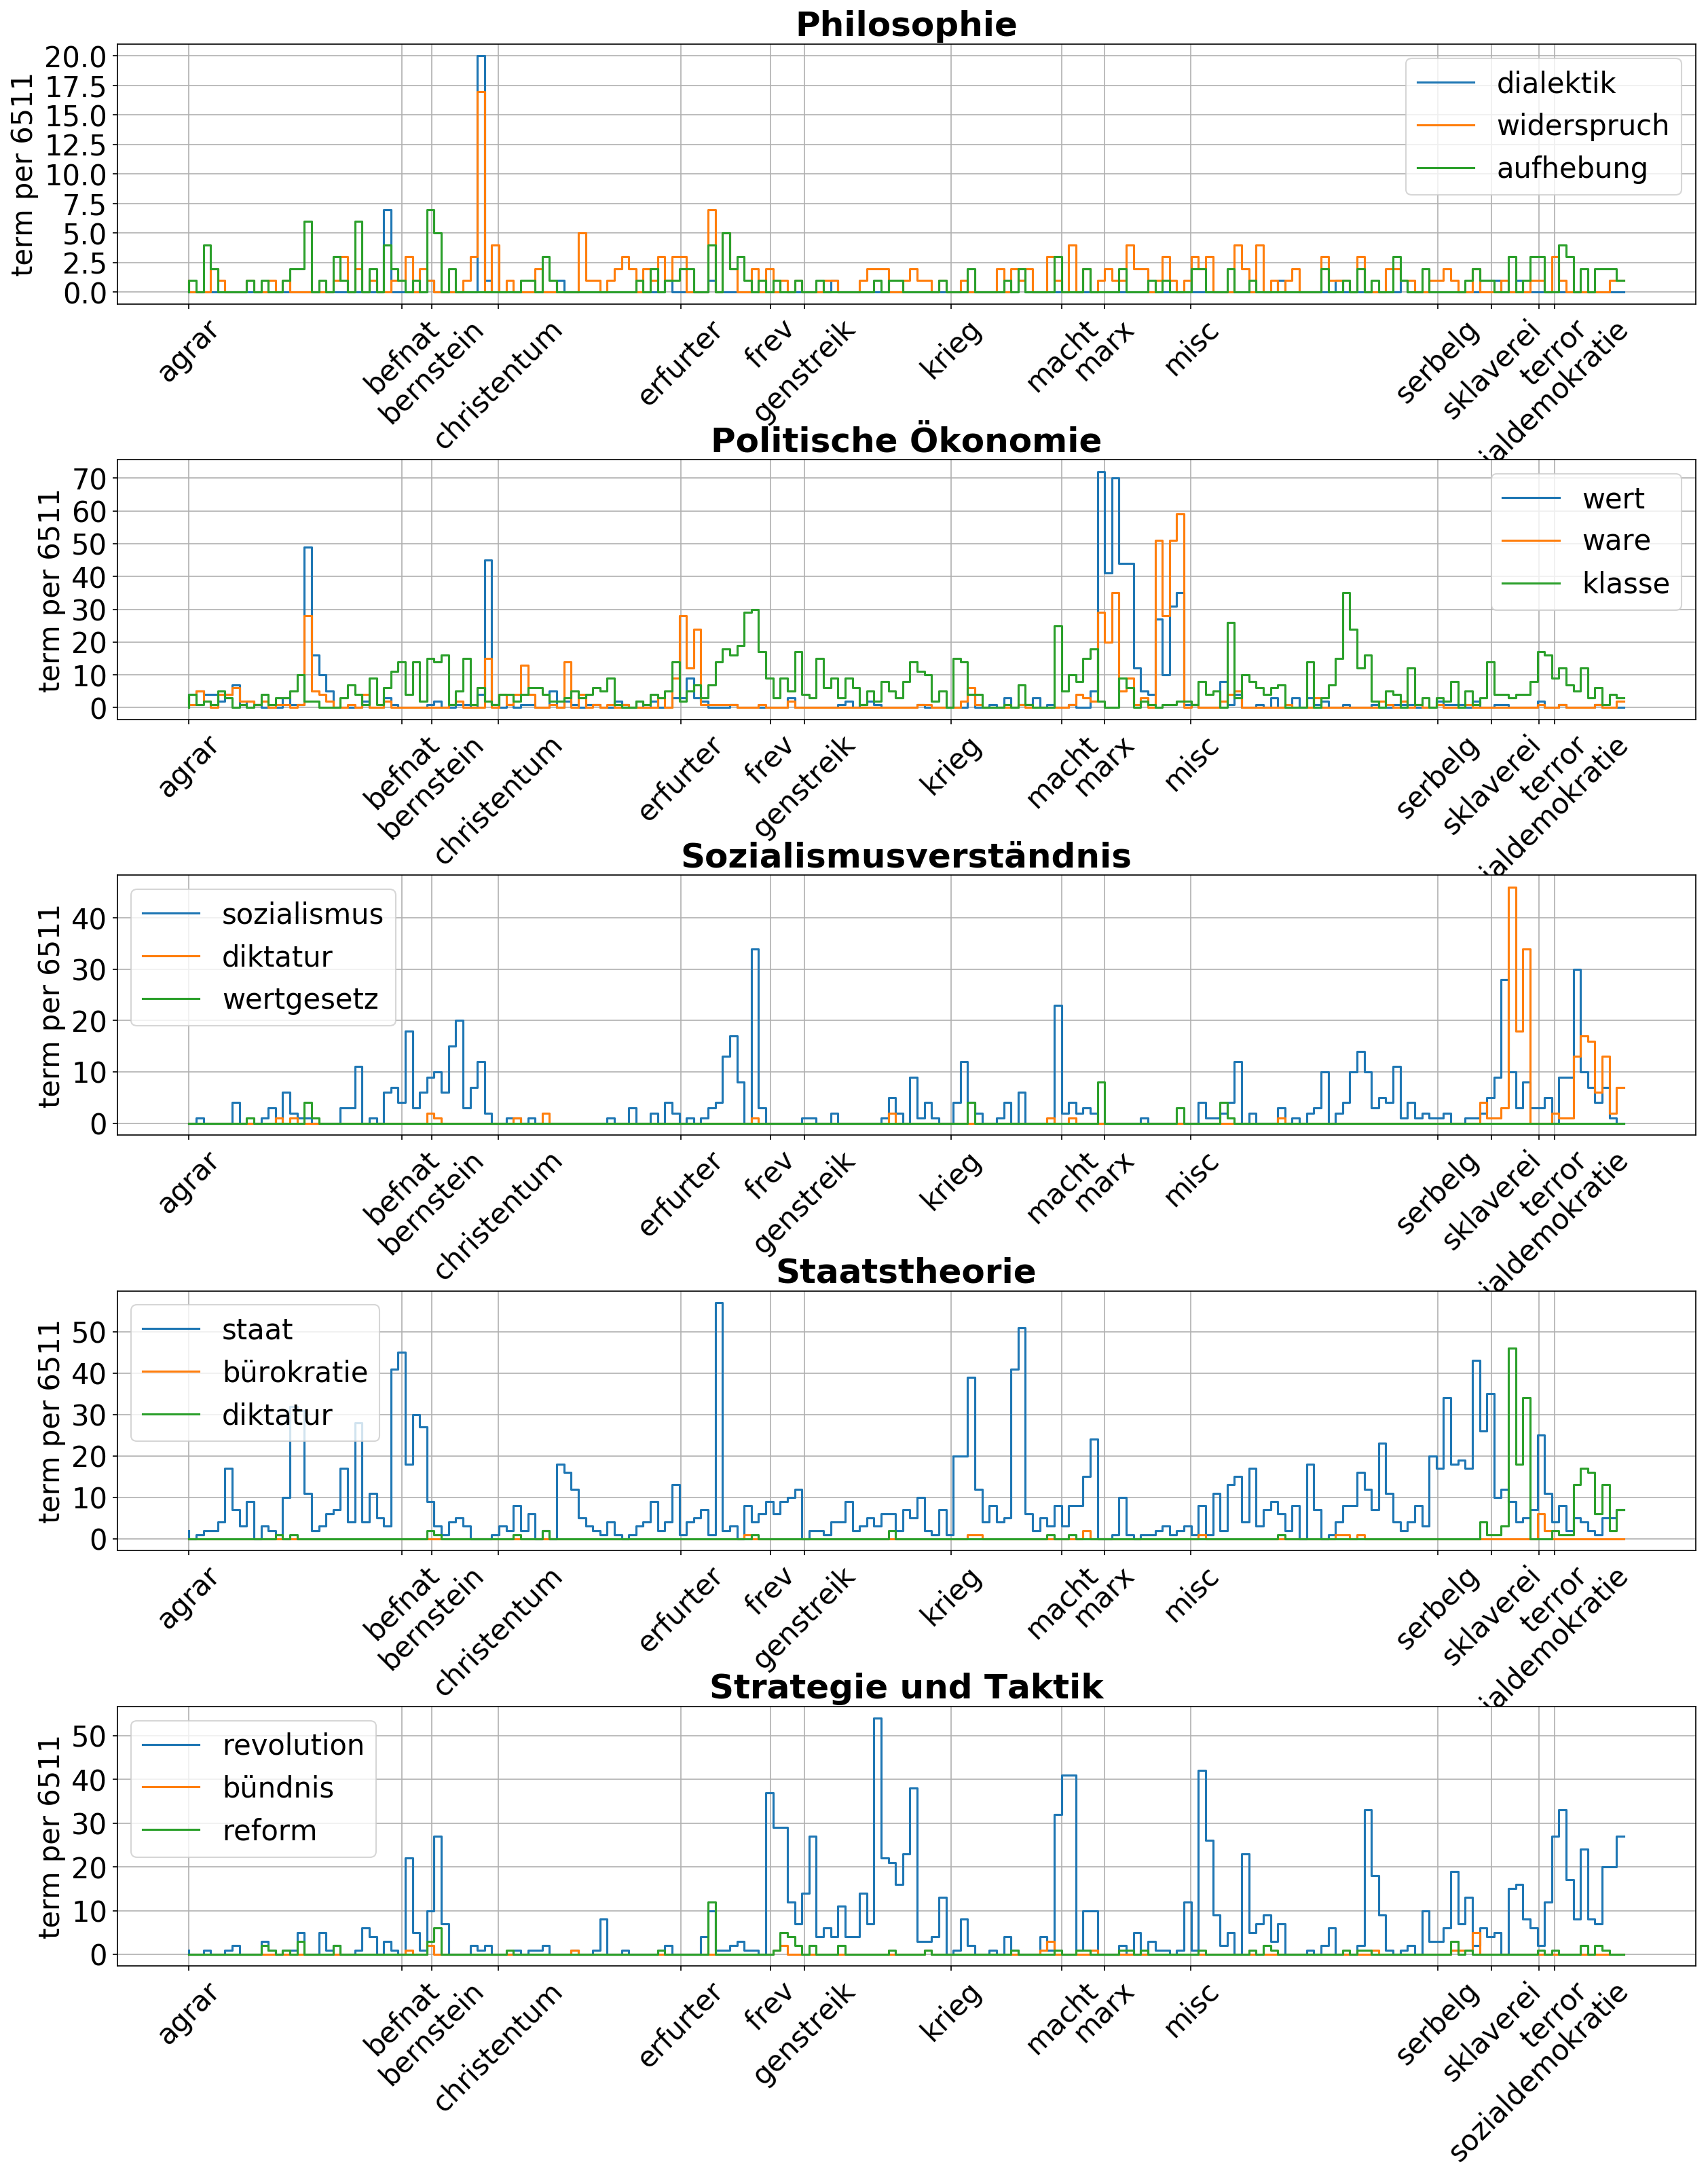

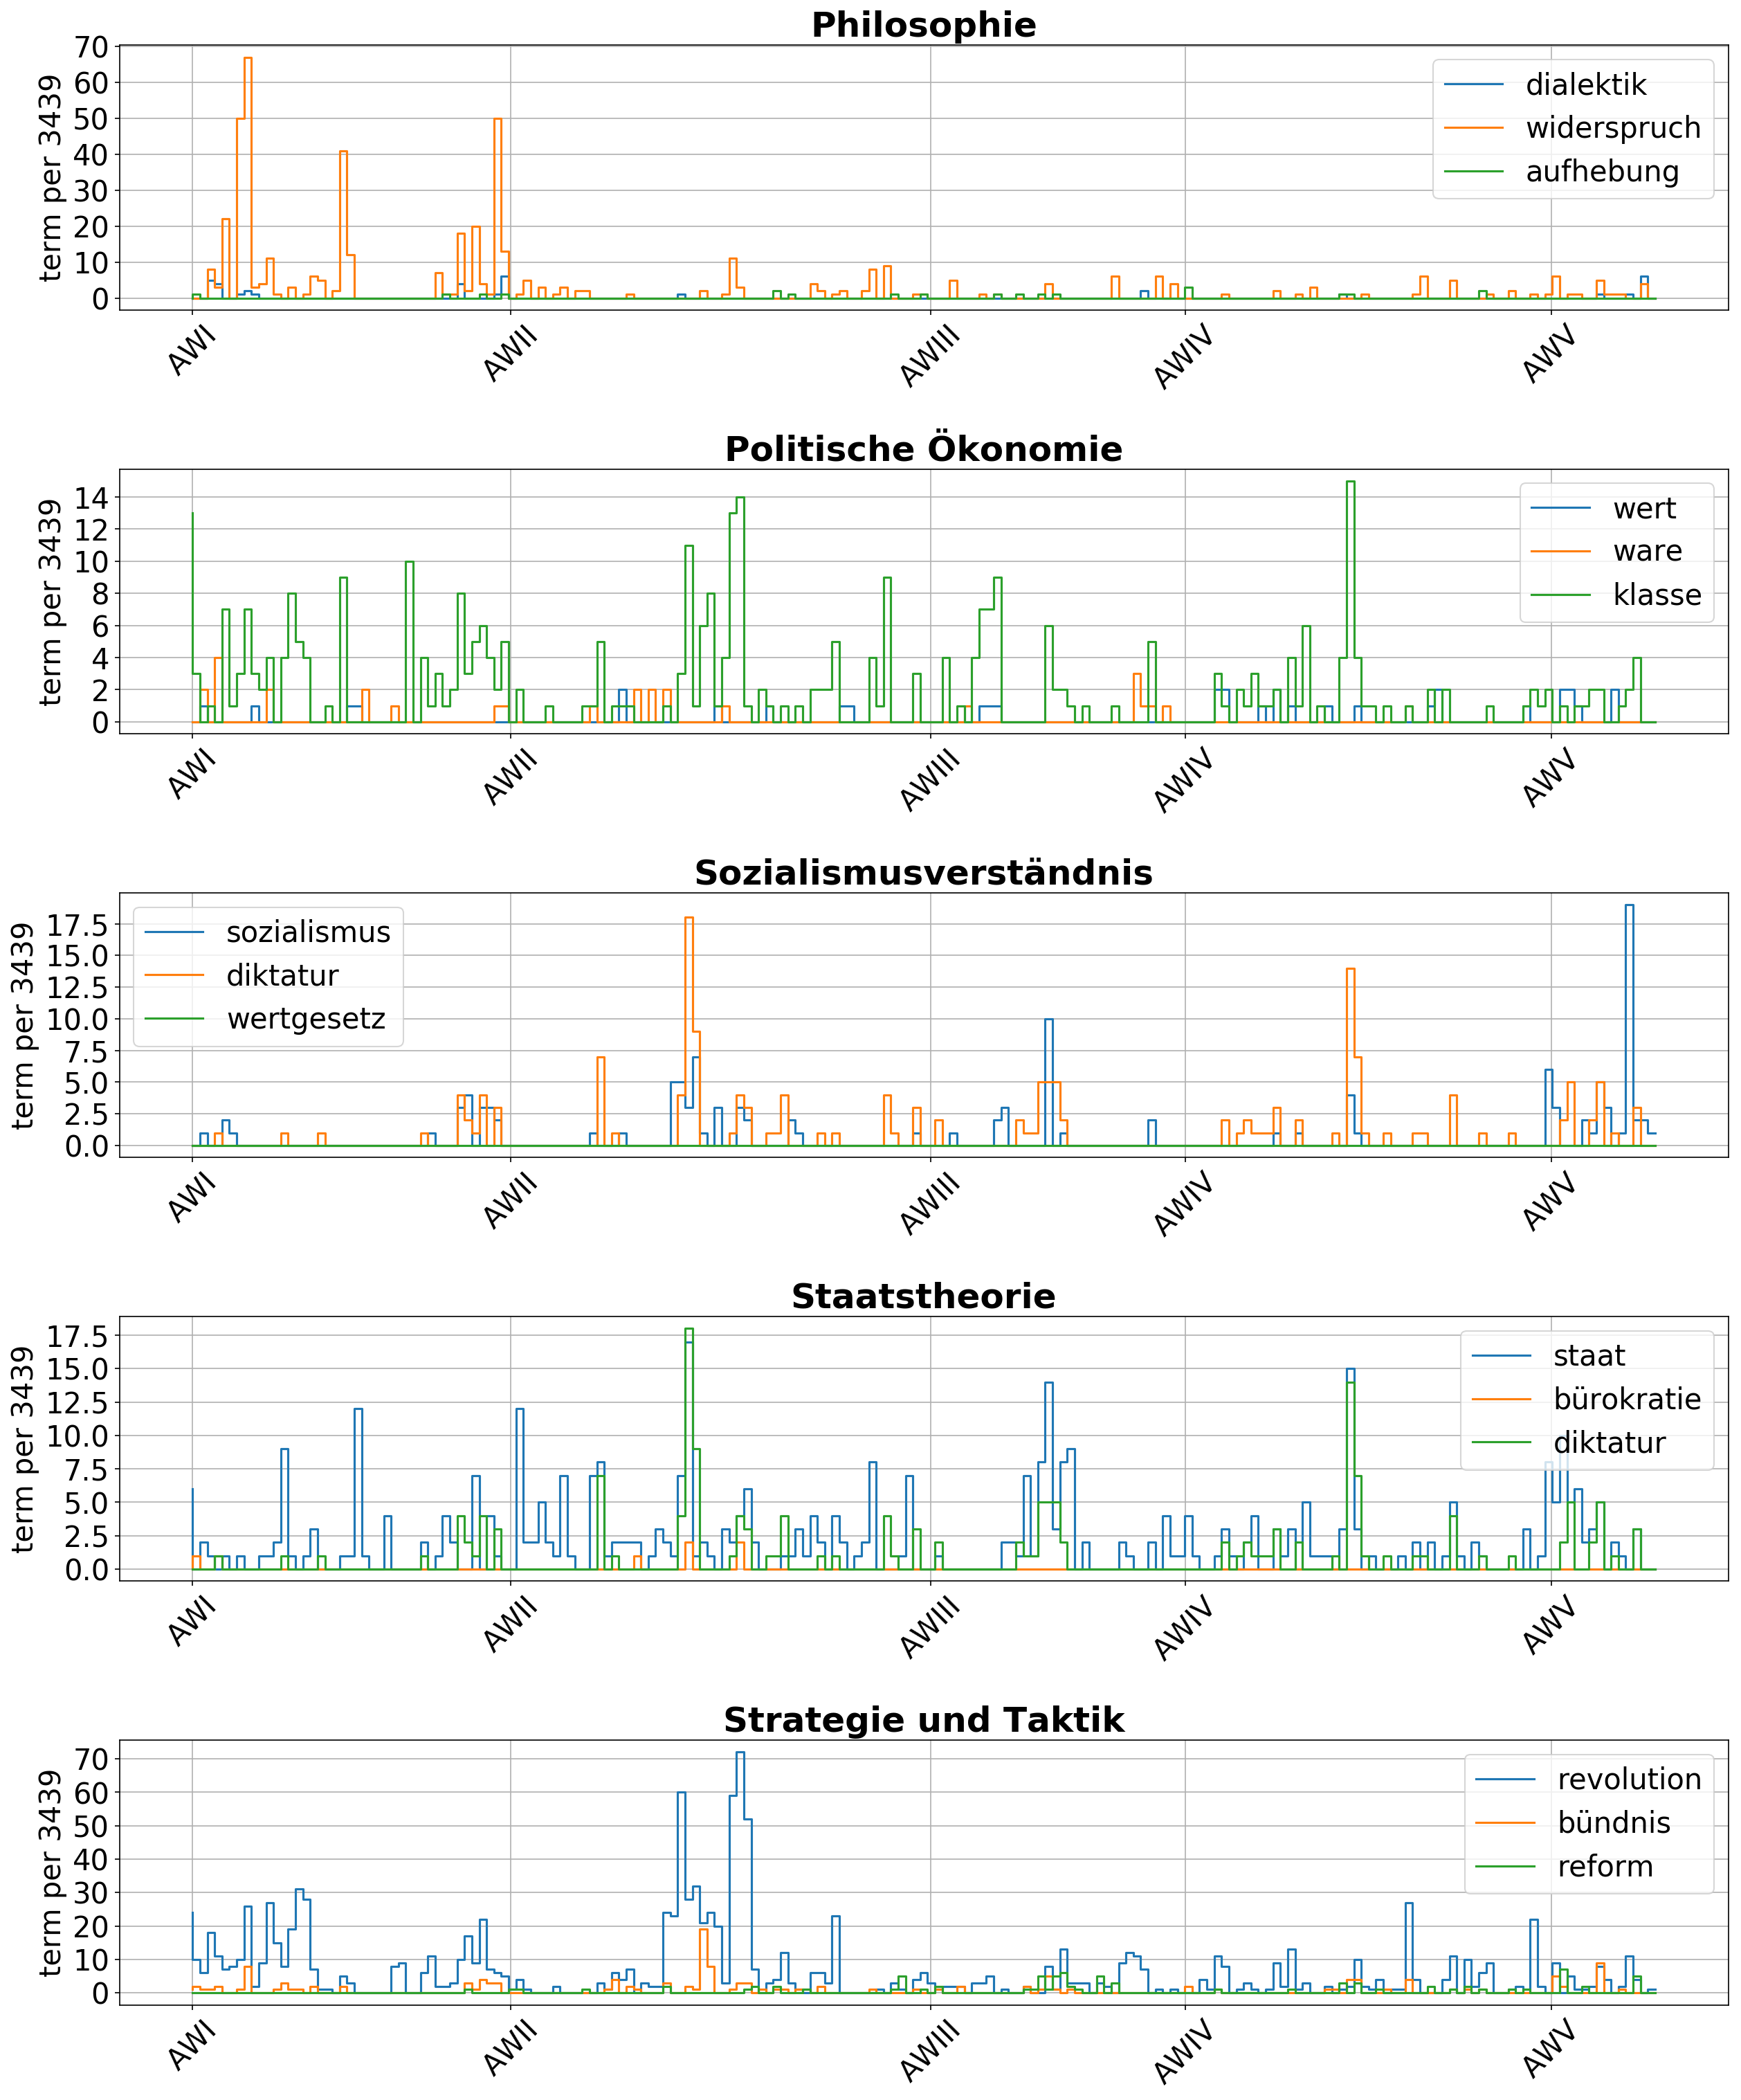

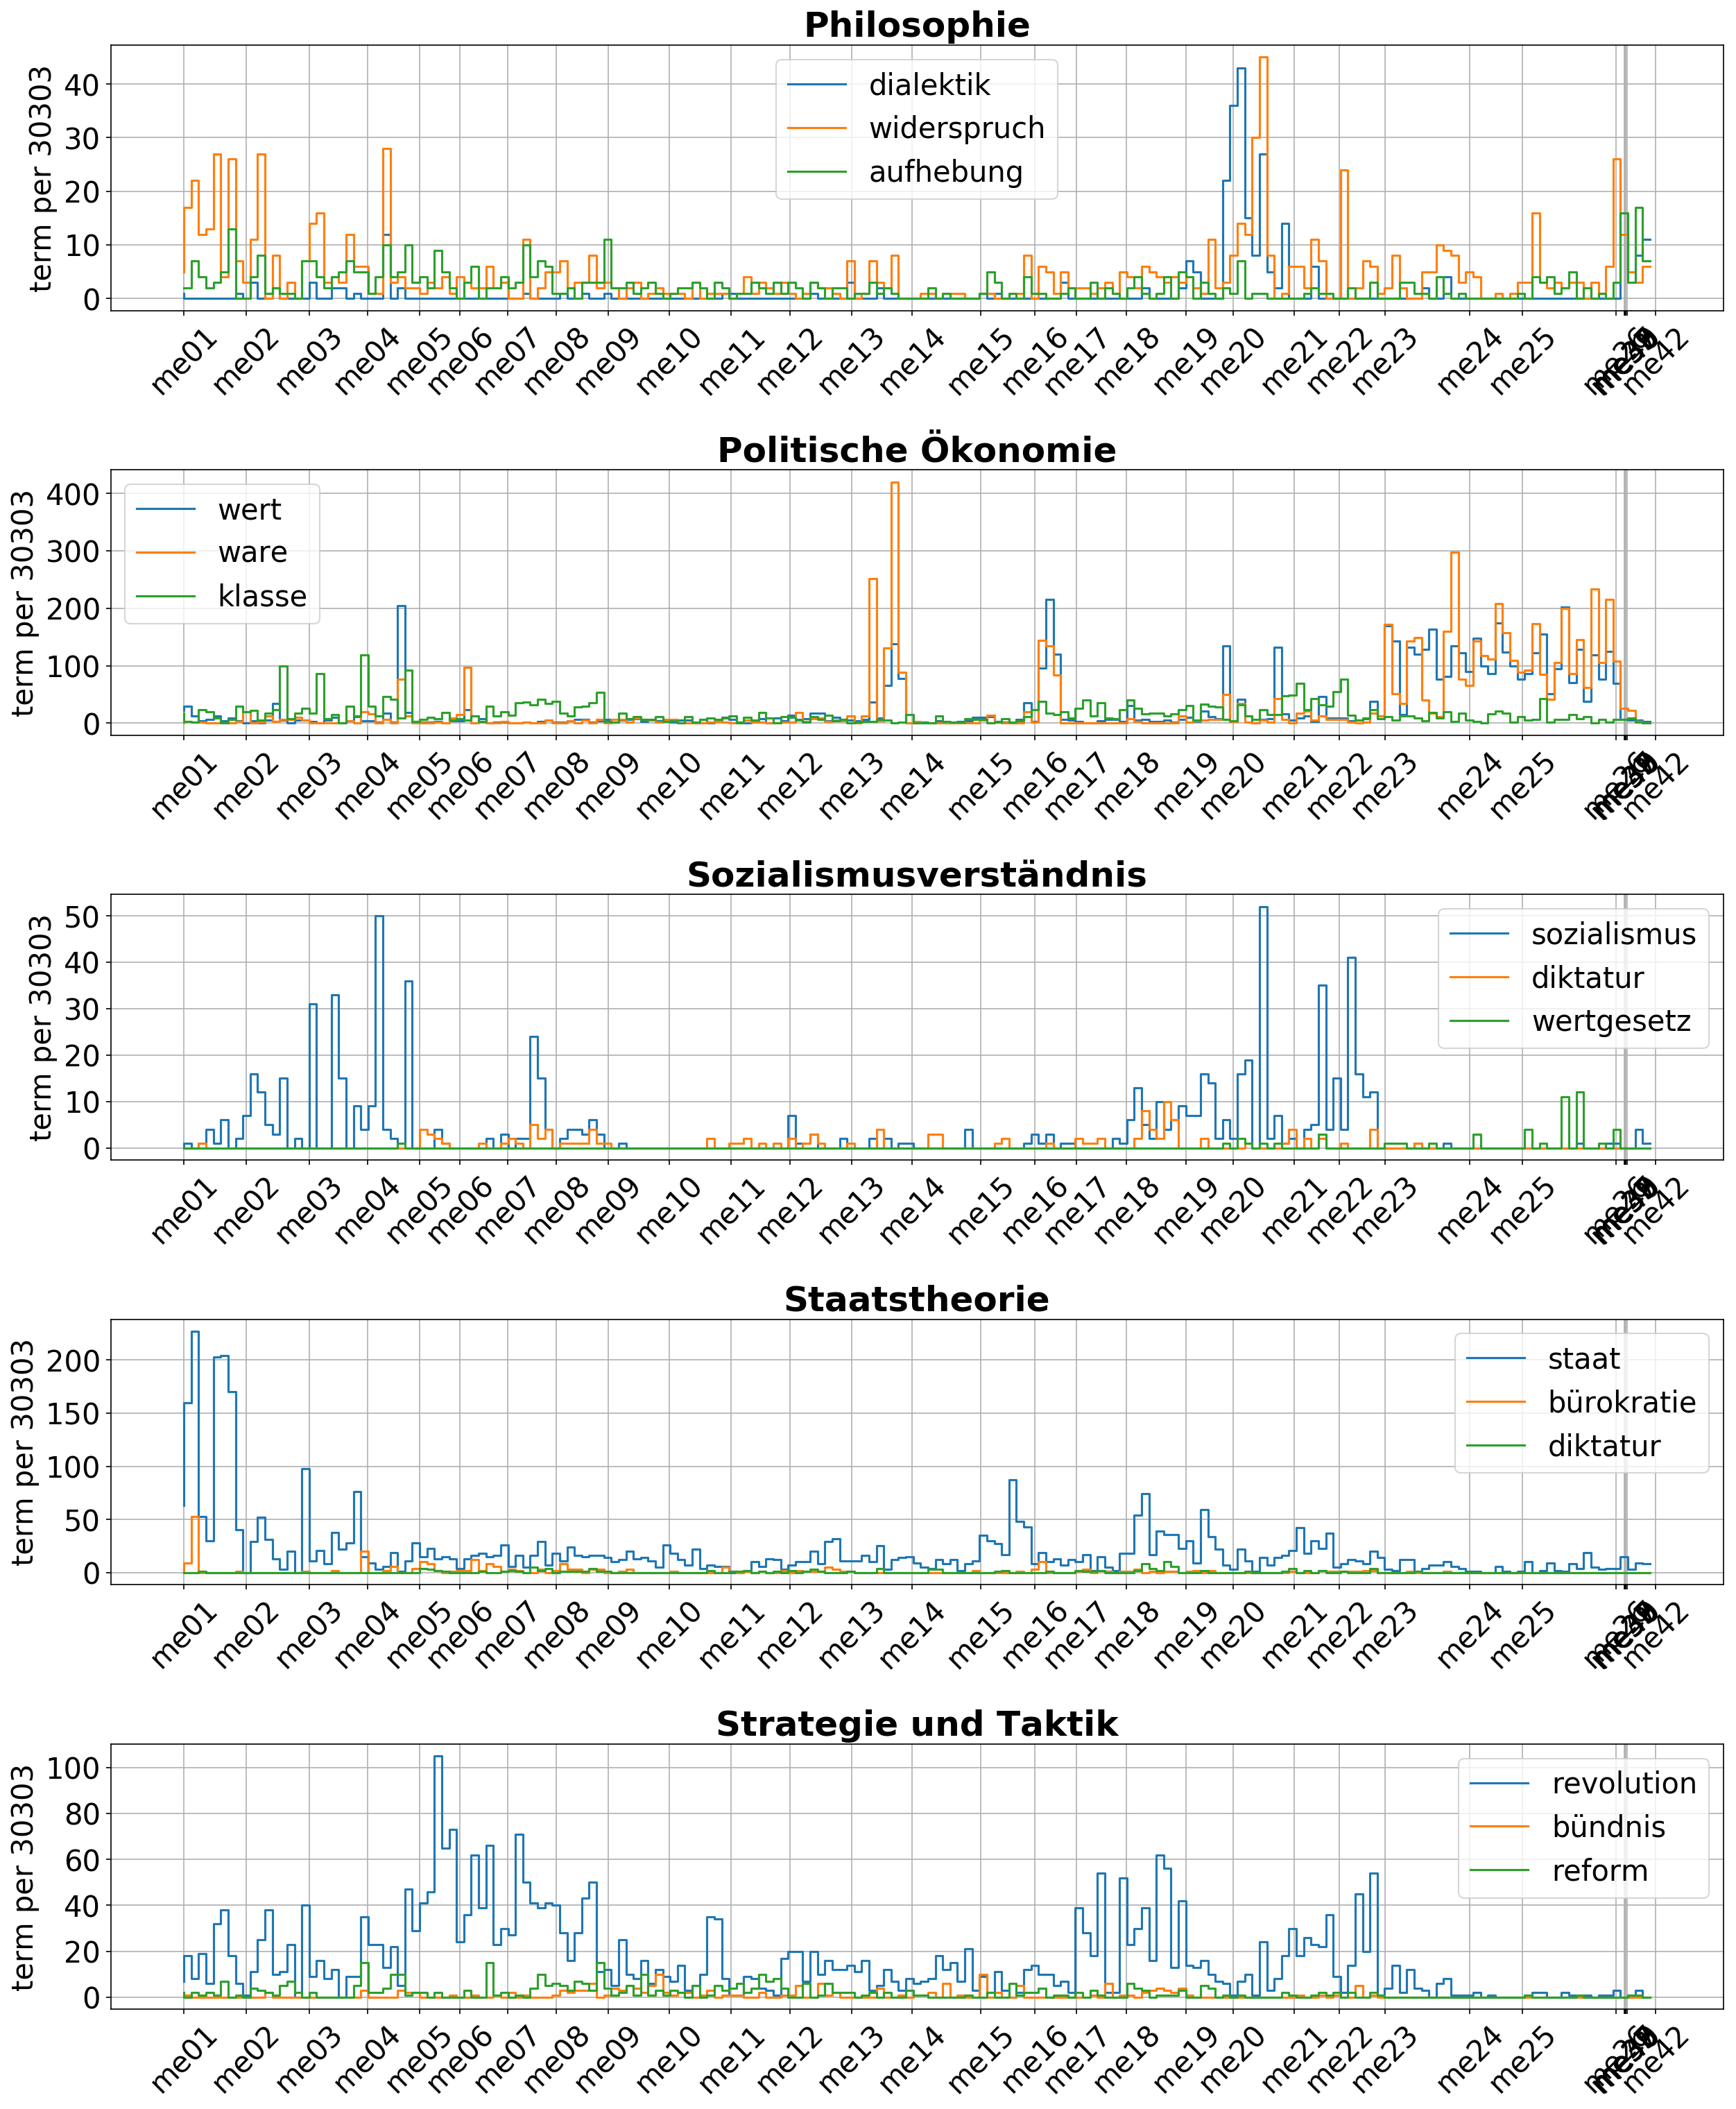

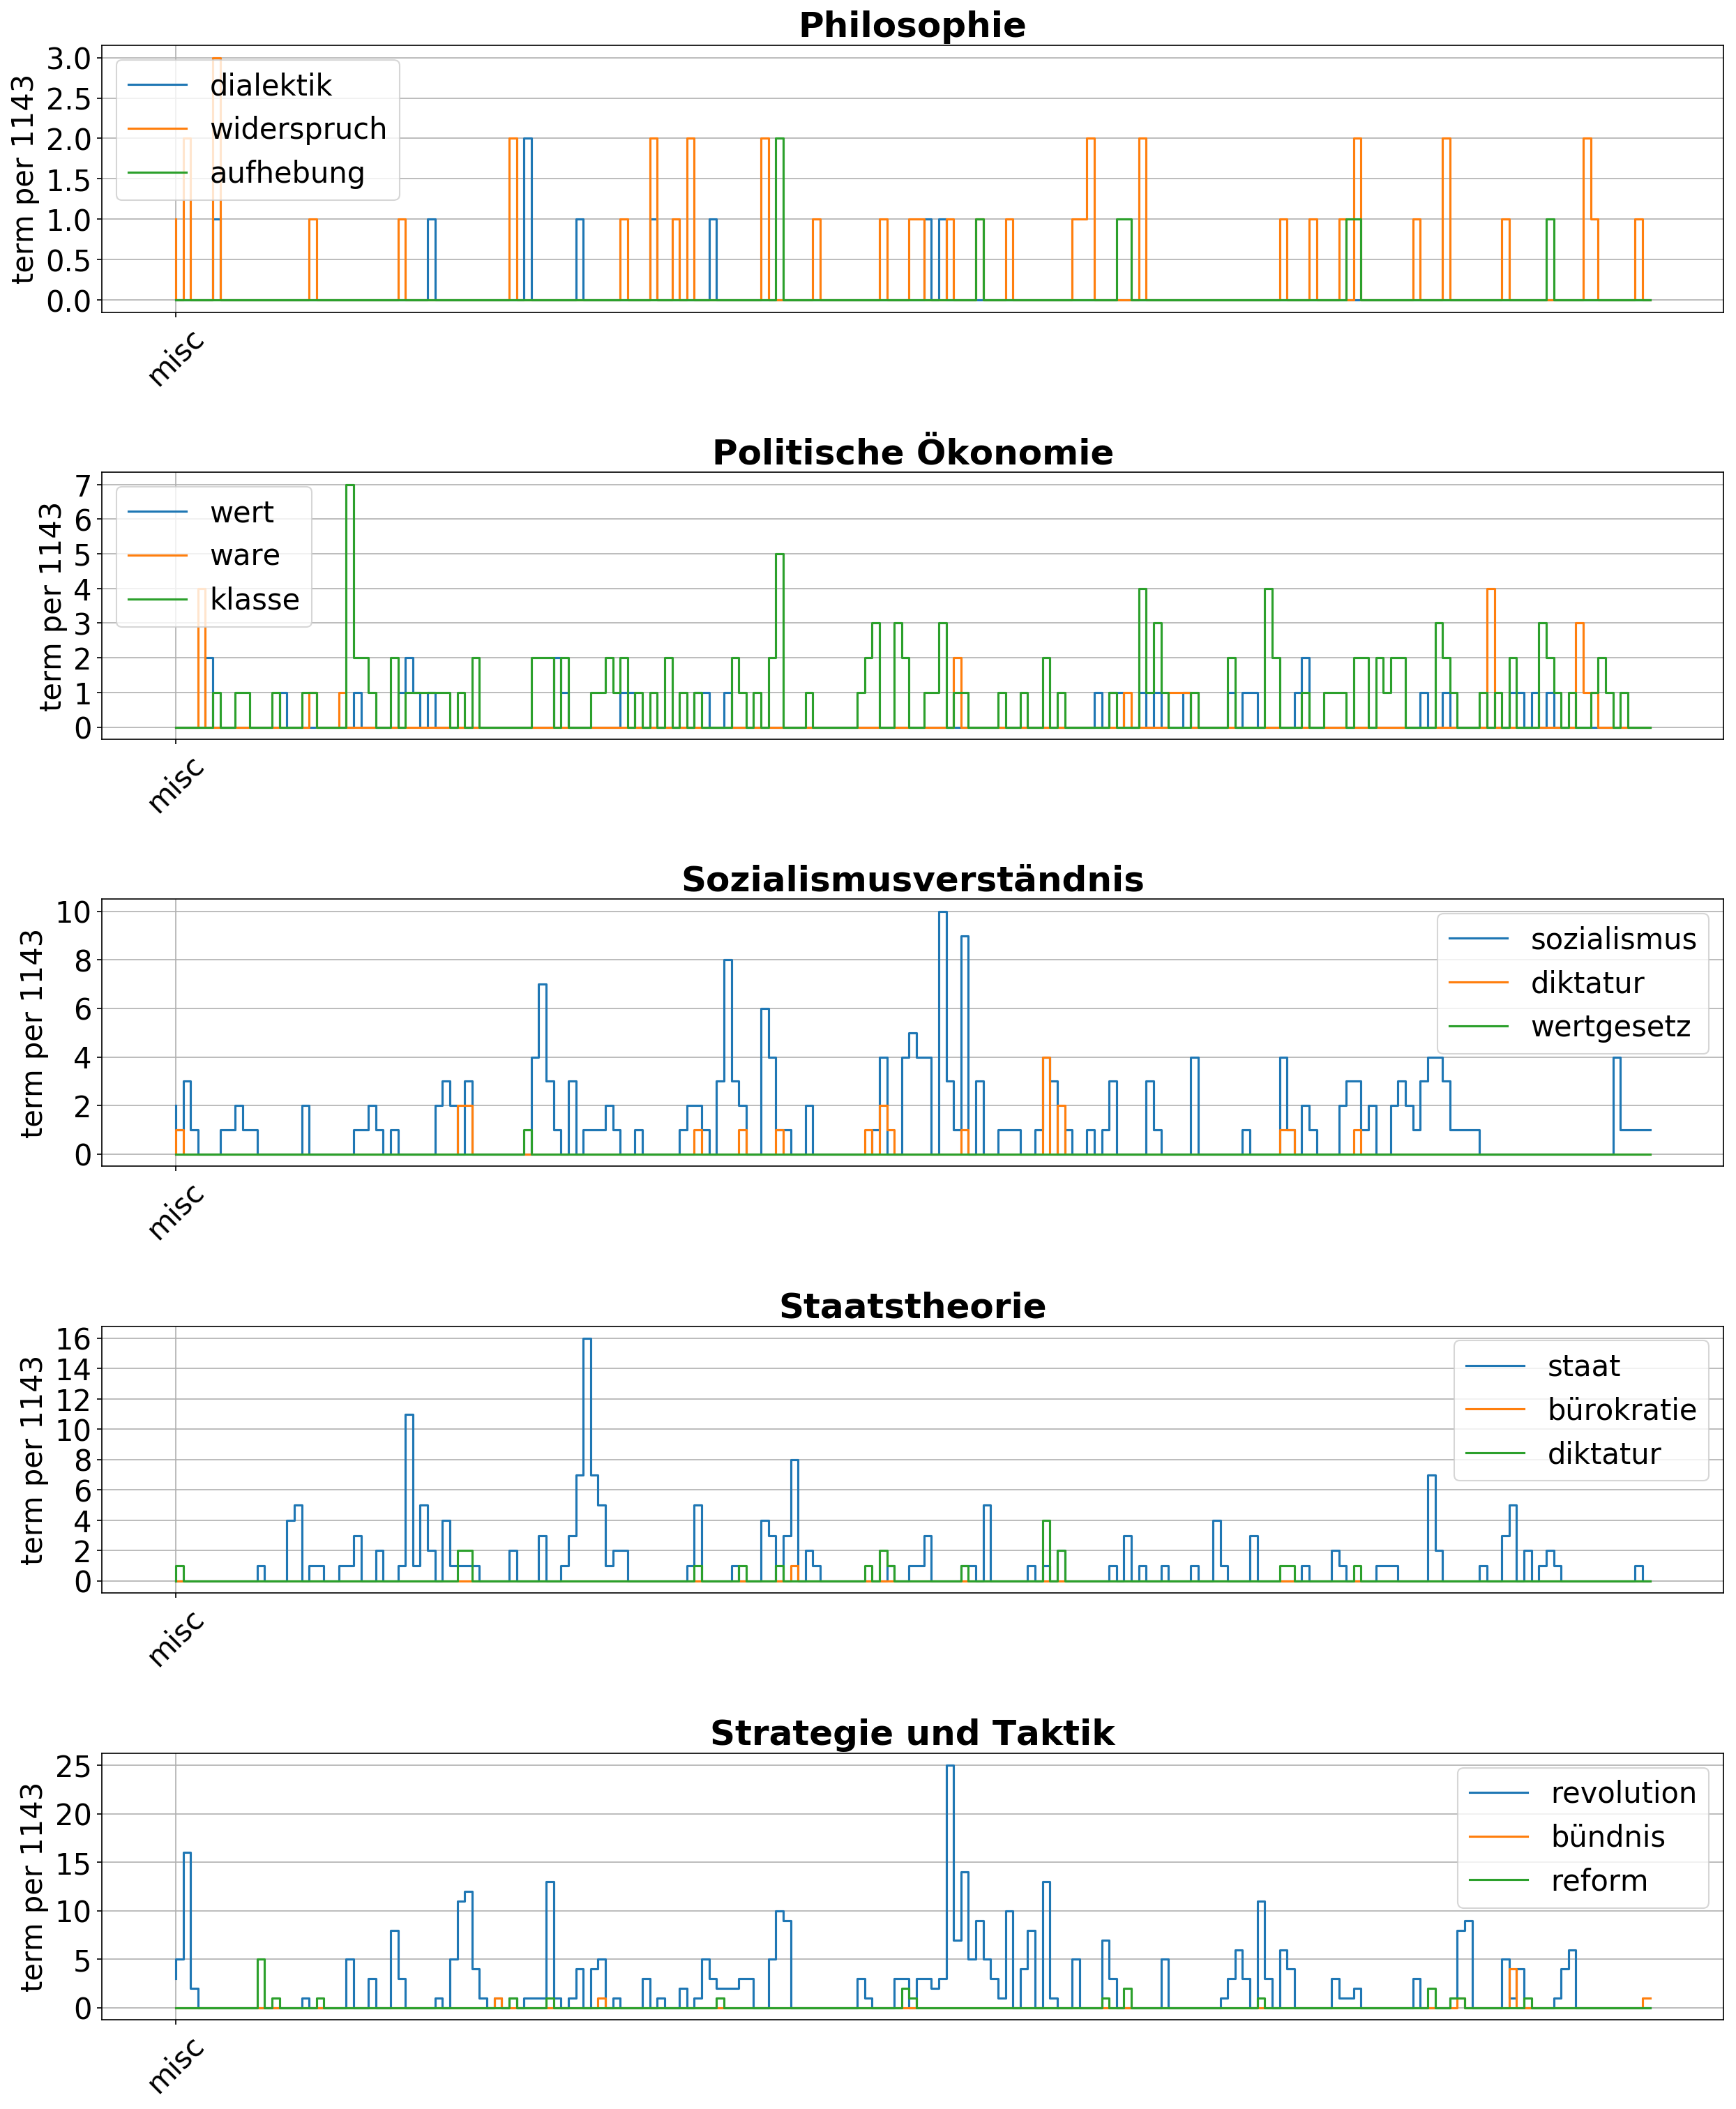

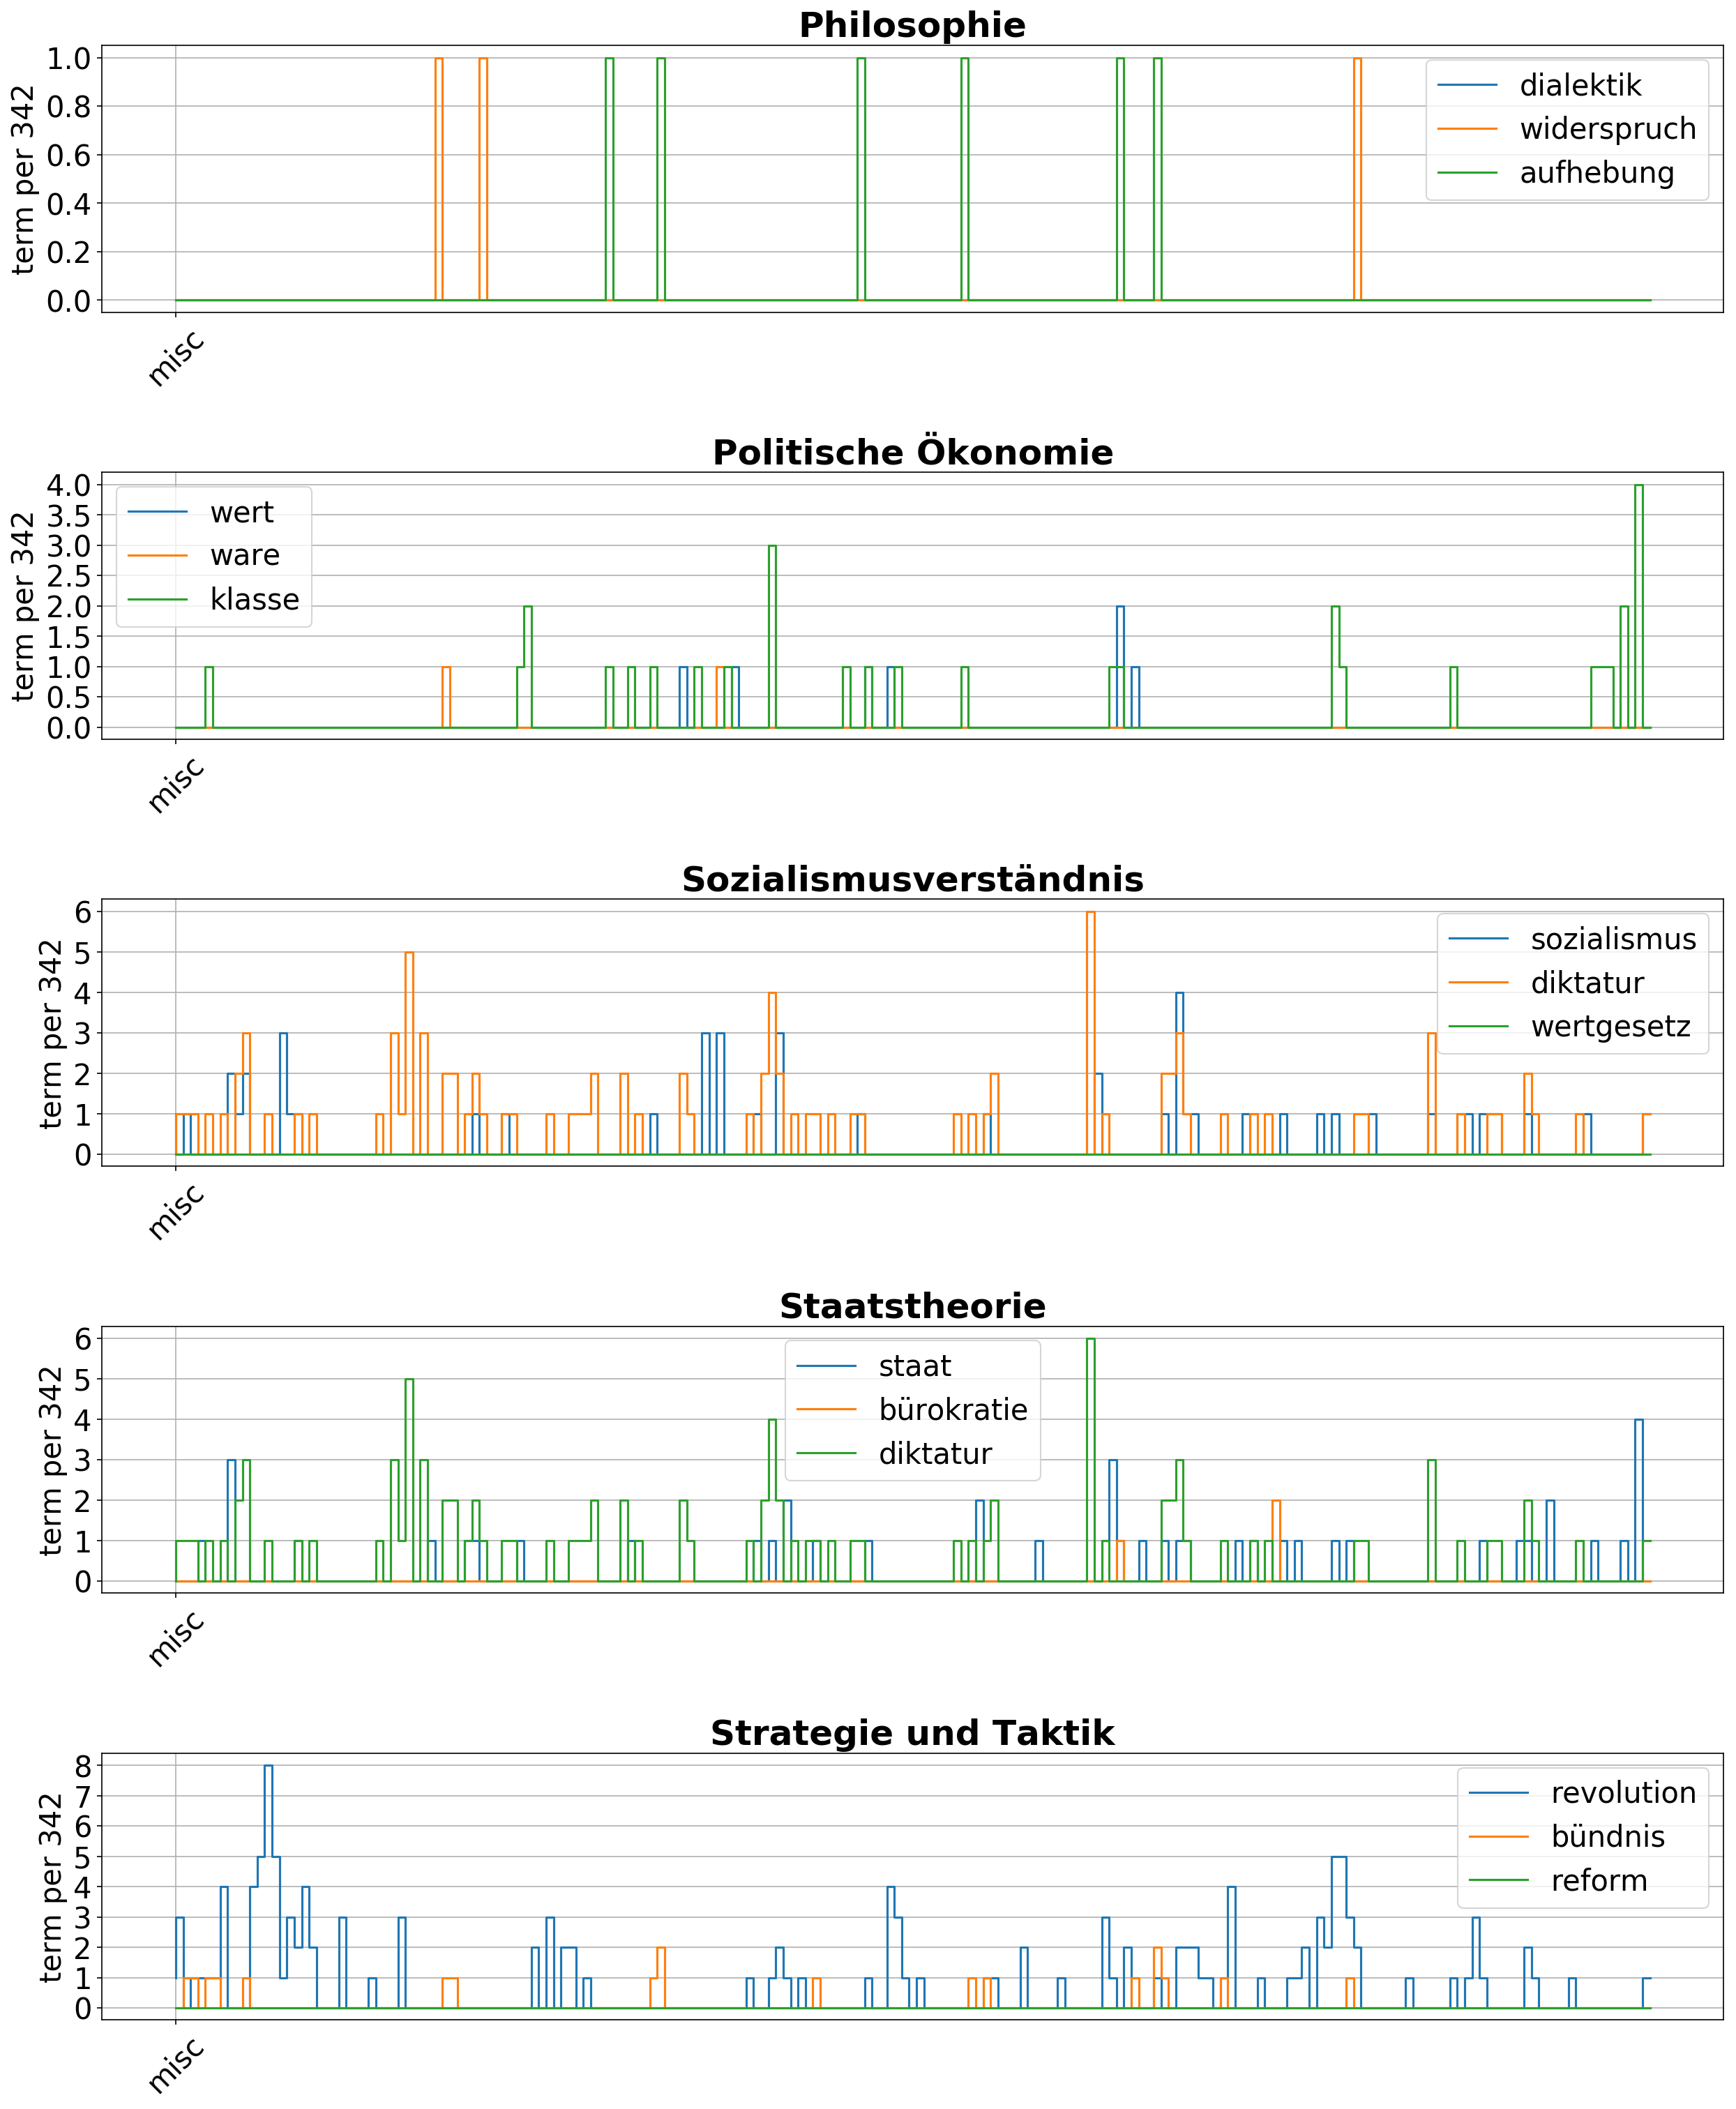

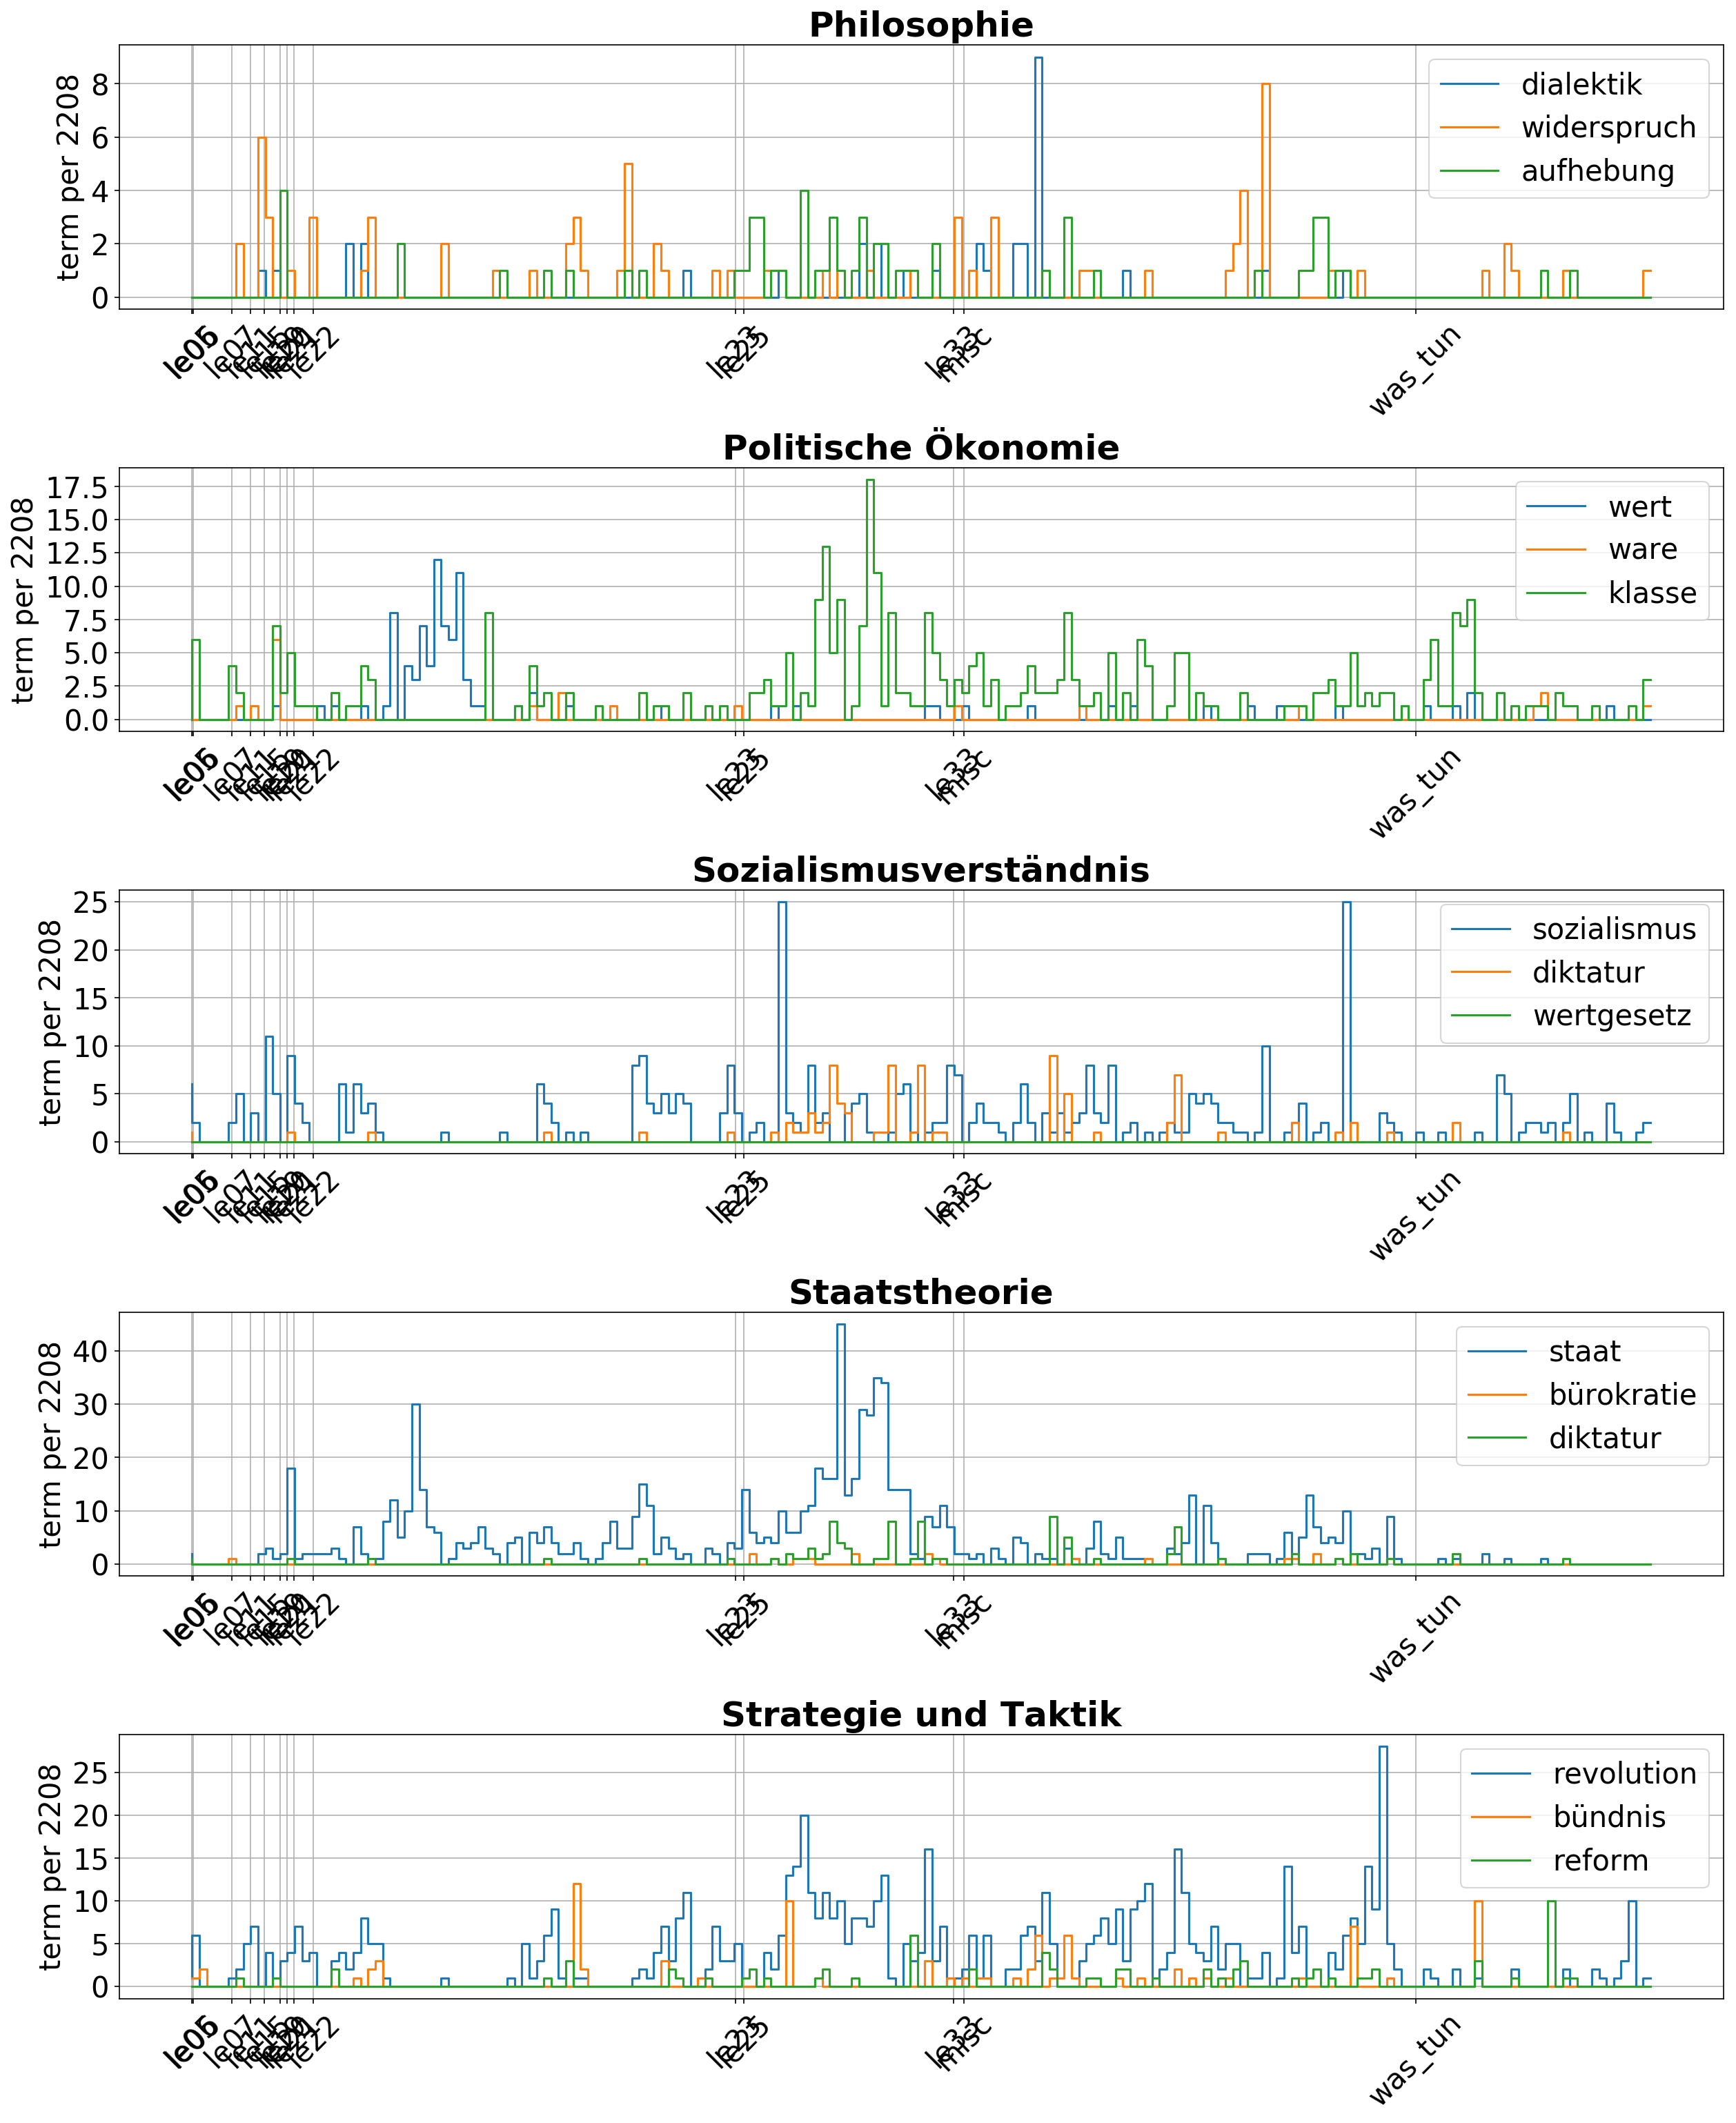

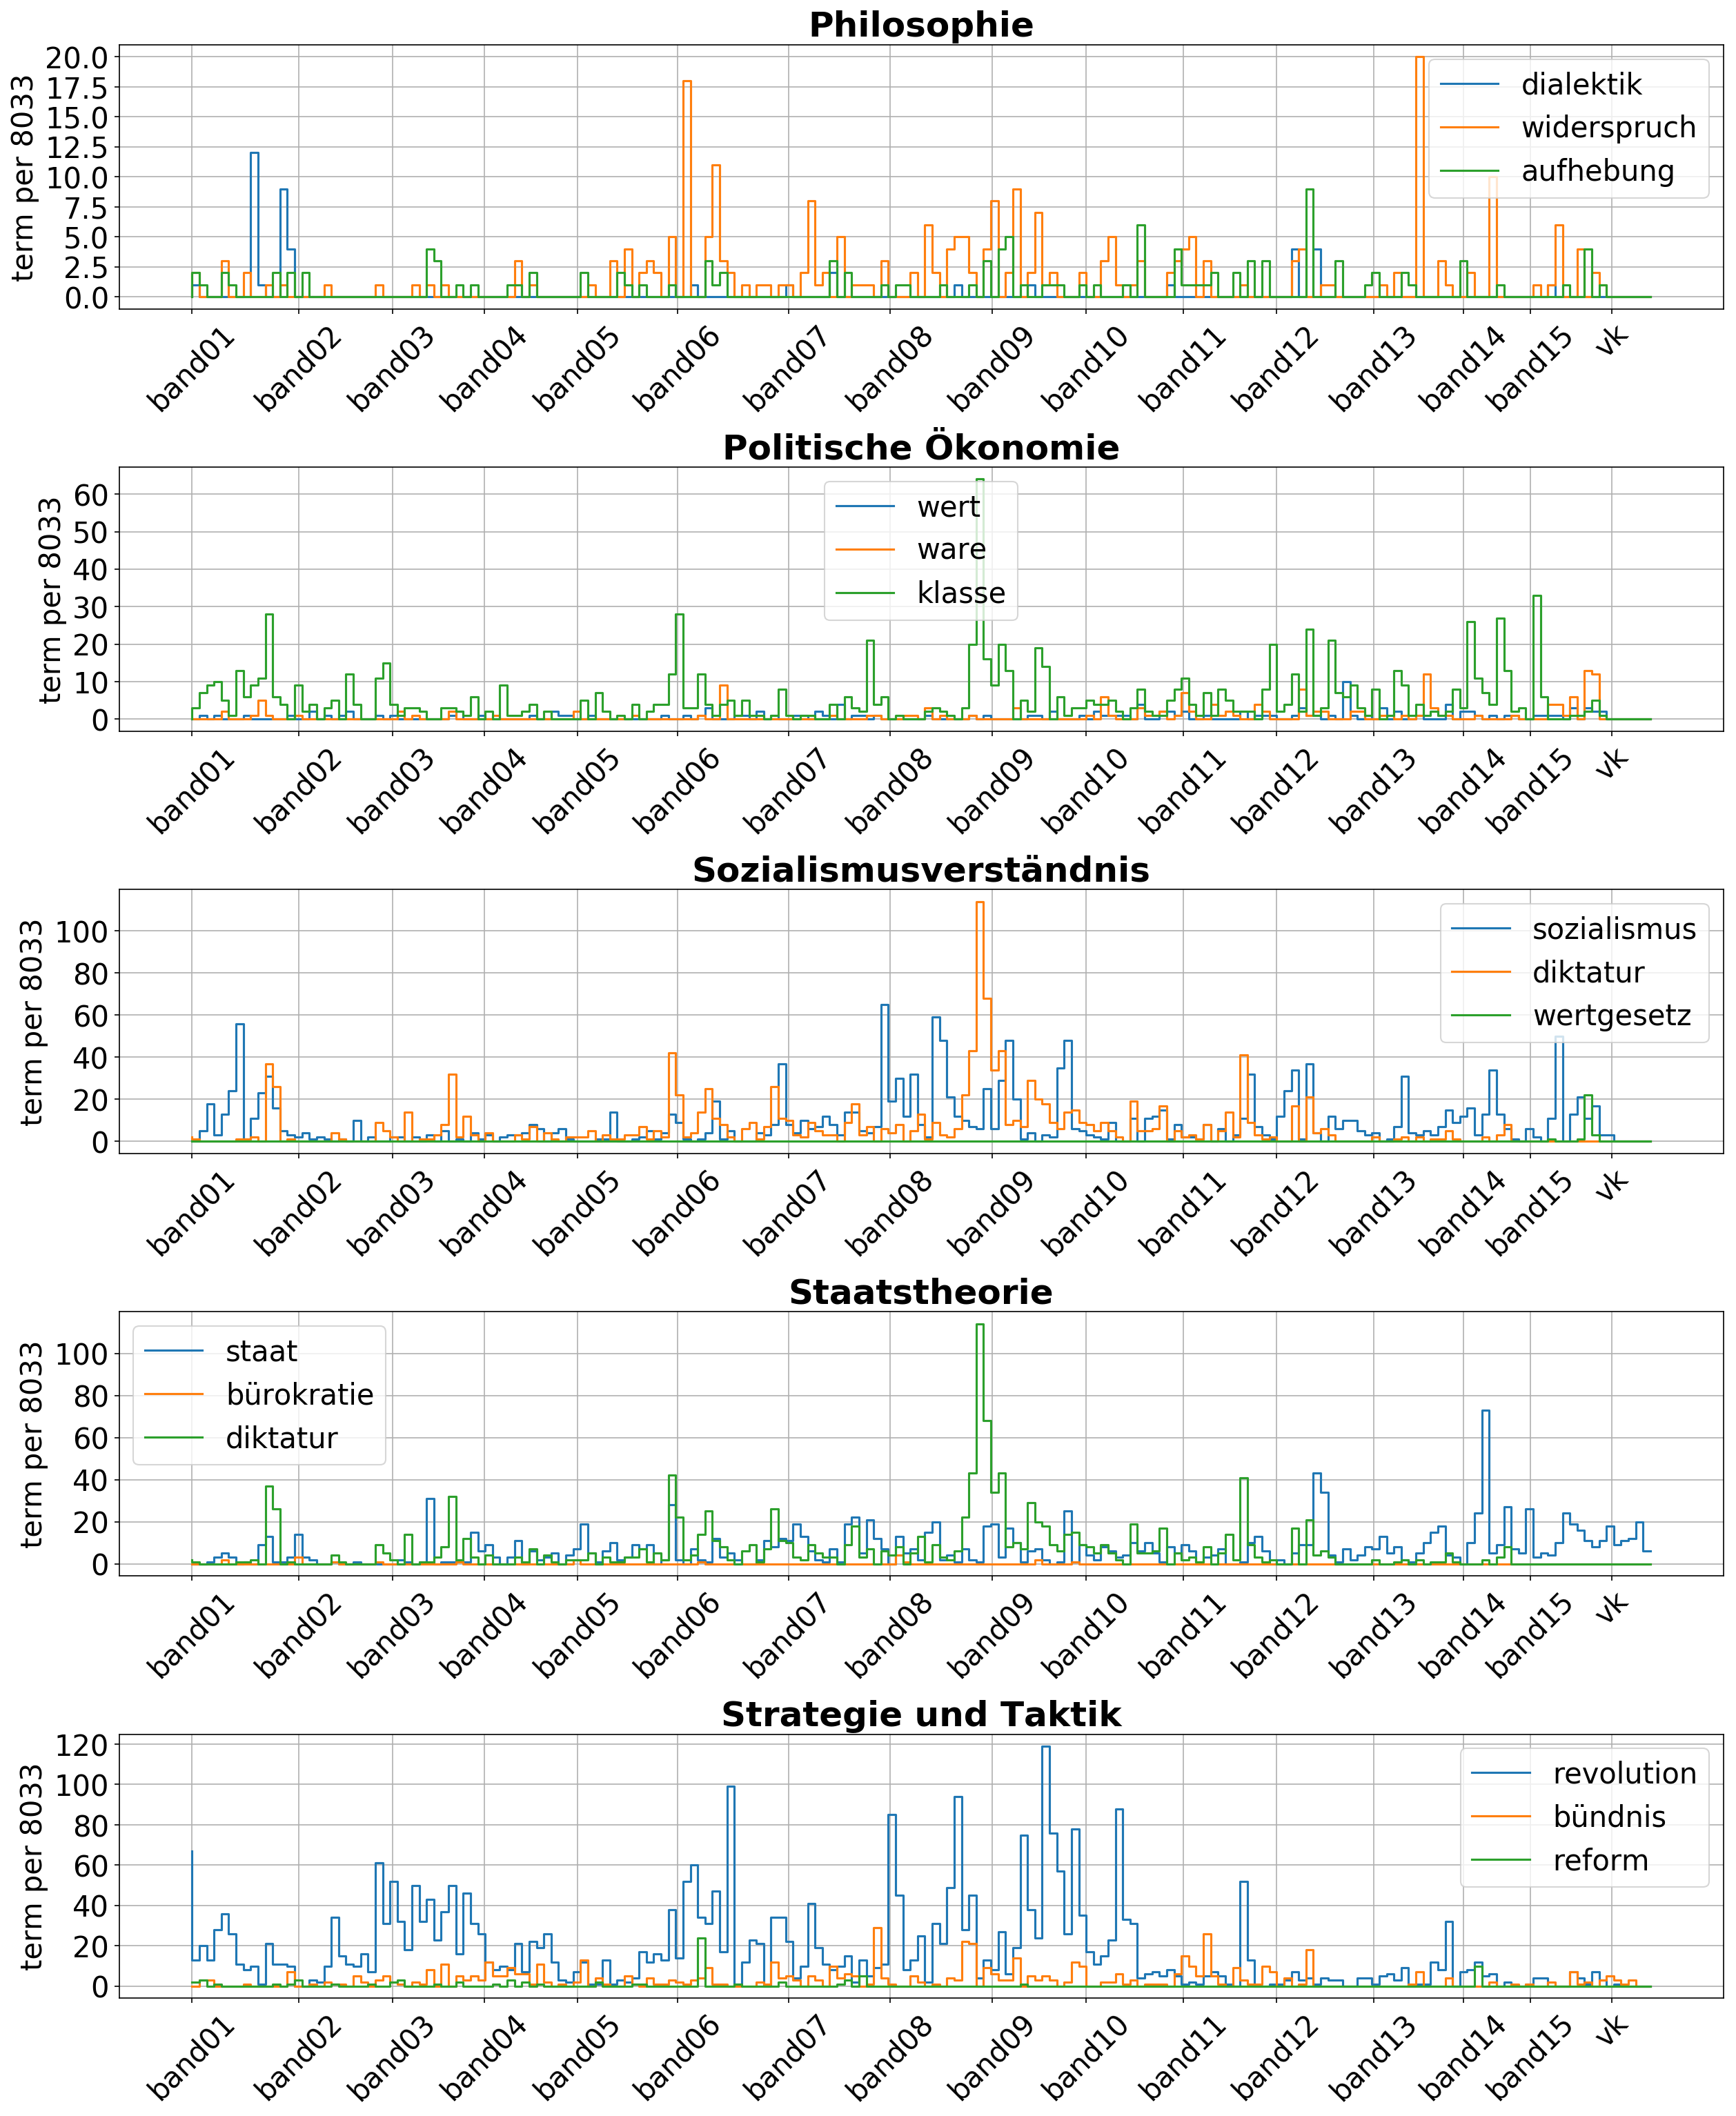

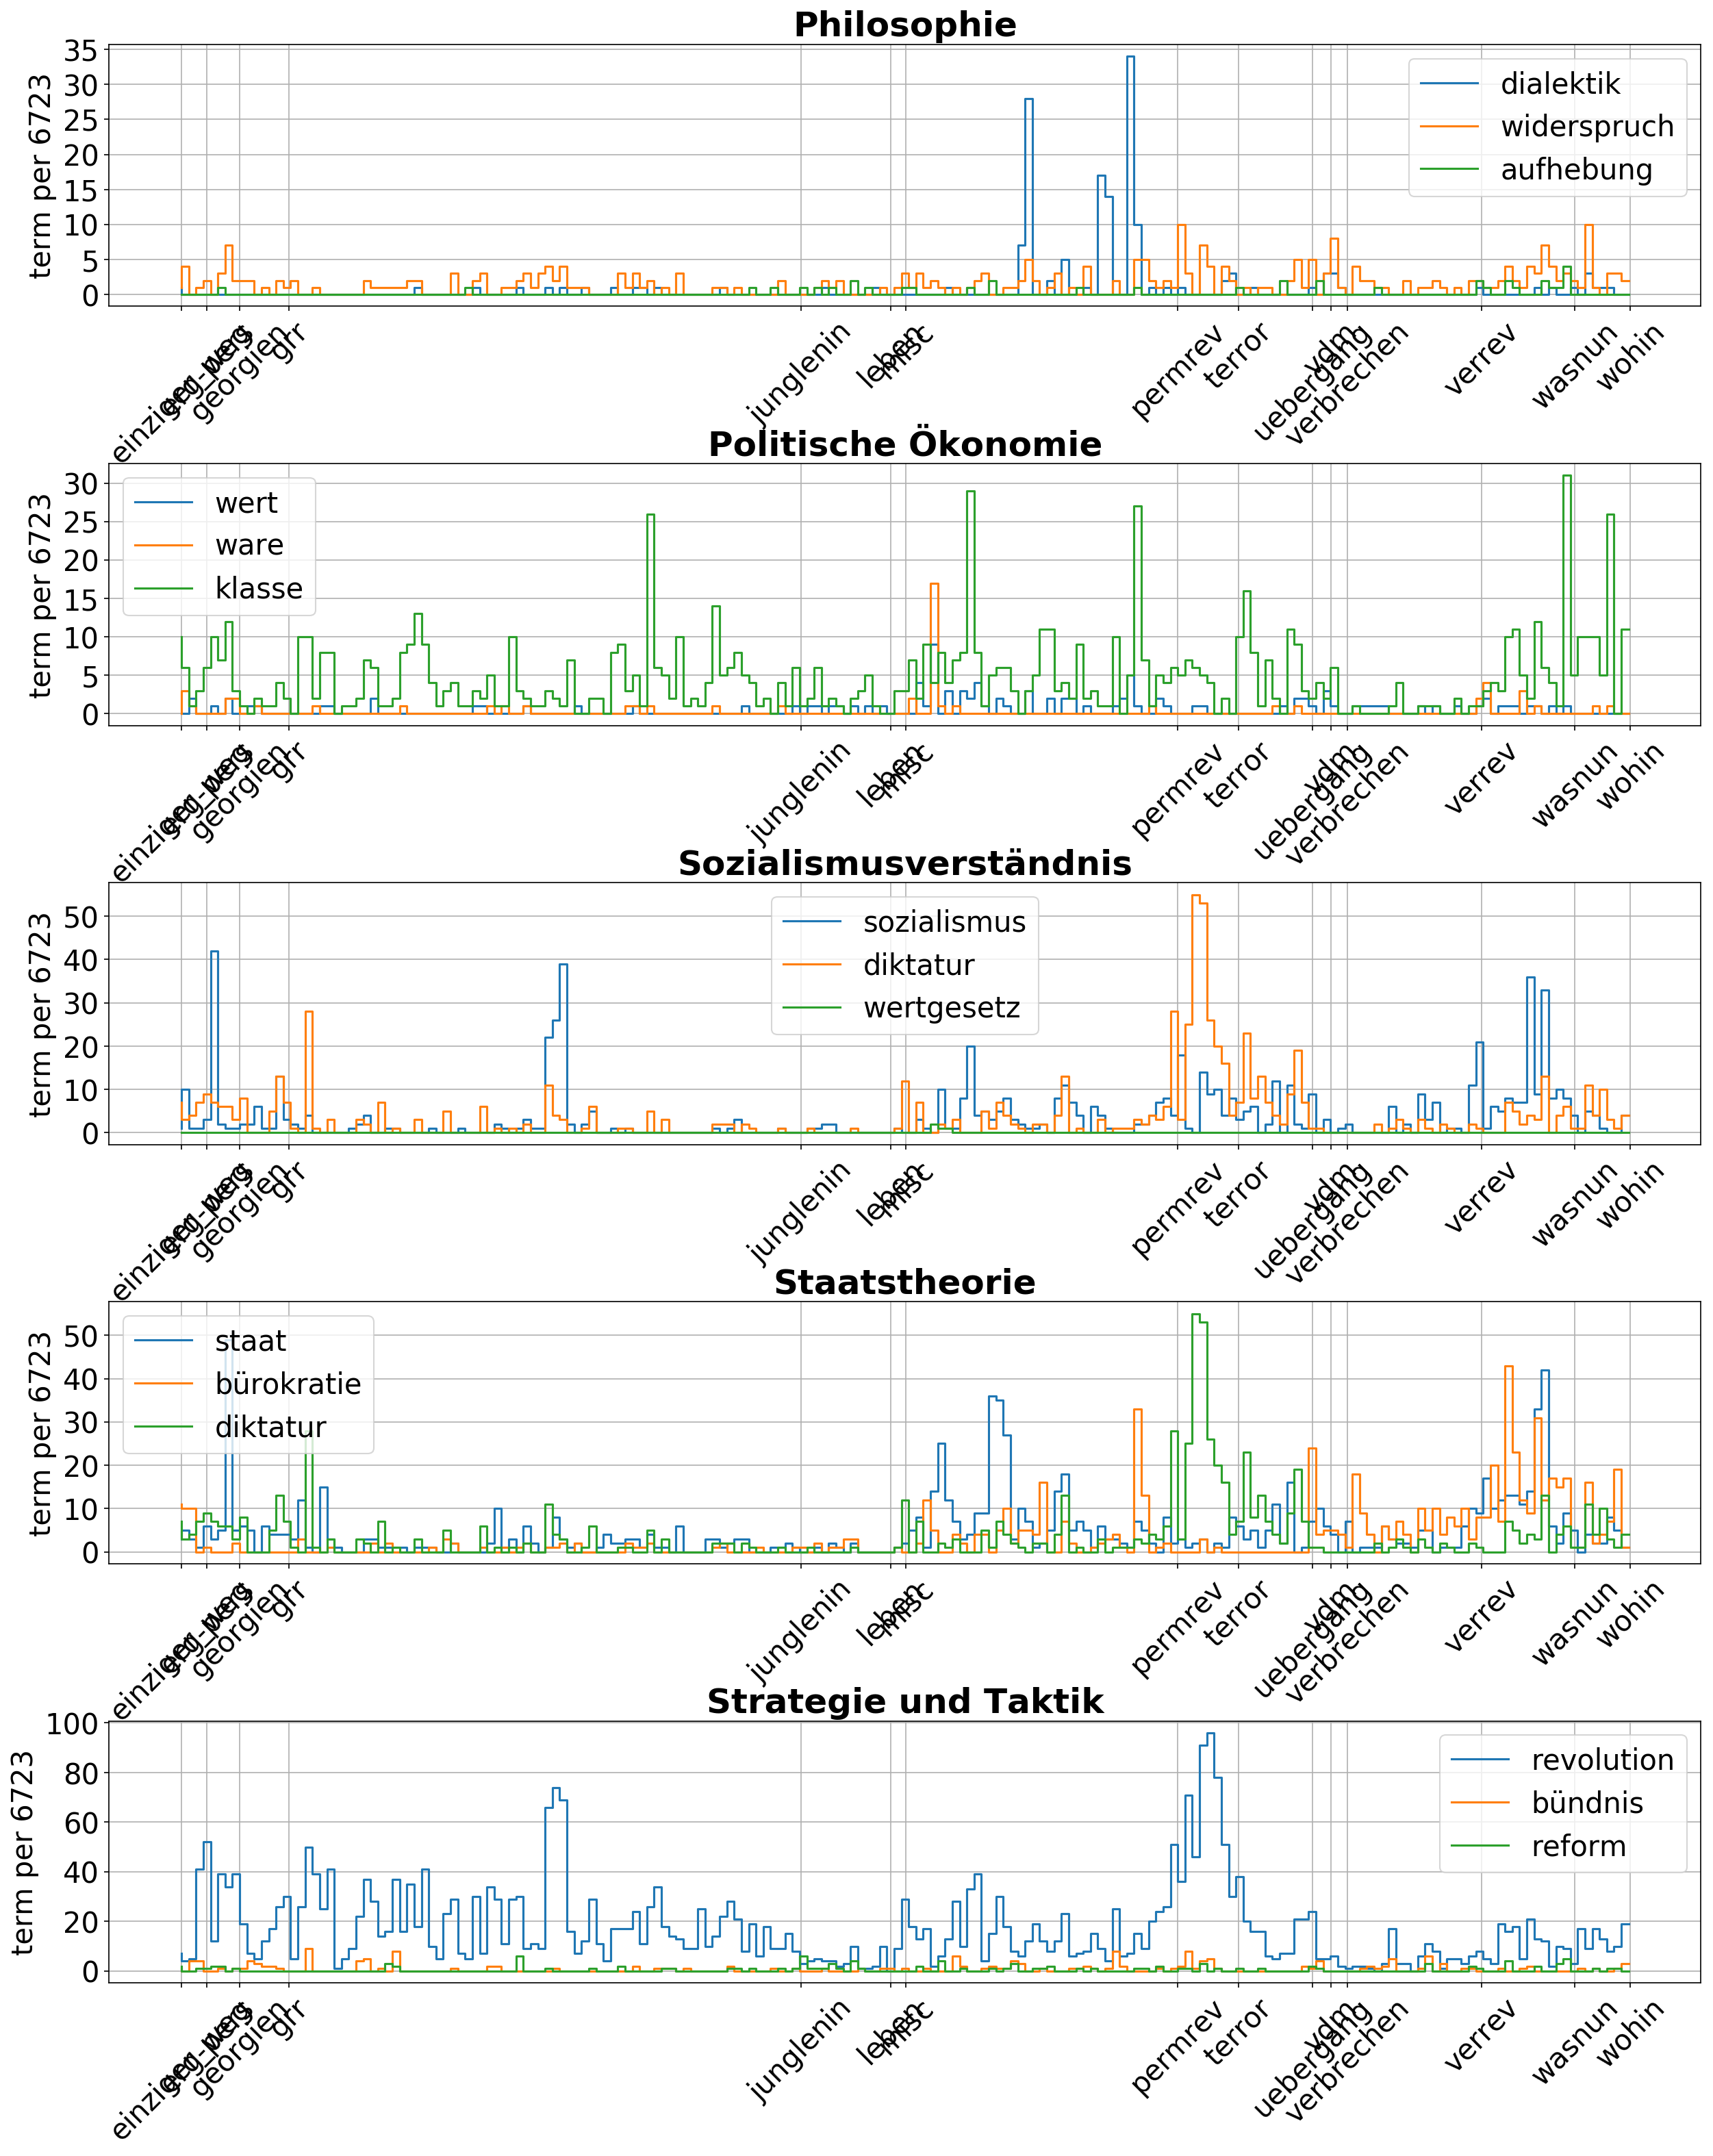

In [19]:
for author in author_dict.keys():
    print(f"Working on {author}...")
    toks = [t[1].lower() for t in tokens[author]]
    terms_locs = {cat: [find_term(toks, t) for t in all_terms[cat]] for cat in term_cats}
    
    number_of_chunks = 200
    
    window_size = len(toks)//number_of_chunks
    step_size = len(toks)//number_of_chunks
    values = {cat: [term_freq(tl, len(toks), window_size, step_size) for tl in terms_locs[cat]] for cat in term_cats}

    fig, axes = plt.subplots(len(term_cats), figsize=(20, 5*len(term_cats)), dpi= 150)

    for i, cat in enumerate(term_cats):
        ax = axes[i]
        for i in range(len(values[cat])):
            # mystep([i for i in range(number_of_chunks)], values[cat][i], ax=ax, label=all_terms[cat][i], linewidth=6)  # step plot version without vertical lines
            ax.step([i for i in range(number_of_chunks)], values[cat][i], label=all_terms[cat][i])  # step plot version
            # ax.plot(values[cat][i], label=all_terms[cat][i])  # line plot version
        ax.legend(prop={"size":20})
        ax.set_ylabel(f"term per {window_size}", fontsize=20)
        ticks = [w["index"]/step_size for w in work_bounds[author]]
        tick_labels = [w["work"] for w in work_bounds[author]]

        ax.set_title(cat, fontsize=24, fontweight="bold")
        ax.set_xticks(ticks)
        ax.set_xticklabels(tick_labels, fontsize=20)
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
        for tick in ax.get_yticklabels():
            tick.set_fontsize(20)
        ax.grid(which="major")

    #plt.gca().set_axis_off()
    plt.subplots_adjust(hspace=.6)

    plt.savefig(f"figures/{author}_total_termdens.pdf", format="pdf", pad_inches=0)
    #plt.savefig(f"figures/{author}test.pdf")

## Work by work

In [18]:
# reconstructing the works
works = []
for w, next_w in zip(work_bounds["marx_engels"], work_bounds["marx_engels"][1:]):
    start = w["index"]
    end = next_w["index"]
    works.append({"work": w["work"], "tokens": tokens["marx_engels"][start:end]})

In [24]:
# calculate using parameters
window_size = 500
step_size = 50
all_y_values = []
for i, work in enumerate(works):
    toks = [t[1].lower() for t in work["tokens"]]
    locs = [find_term(toks, t) for t in terms]
    all_y_values.append([term_freq(l, len(toks), window_size, step_size) for l in locs])

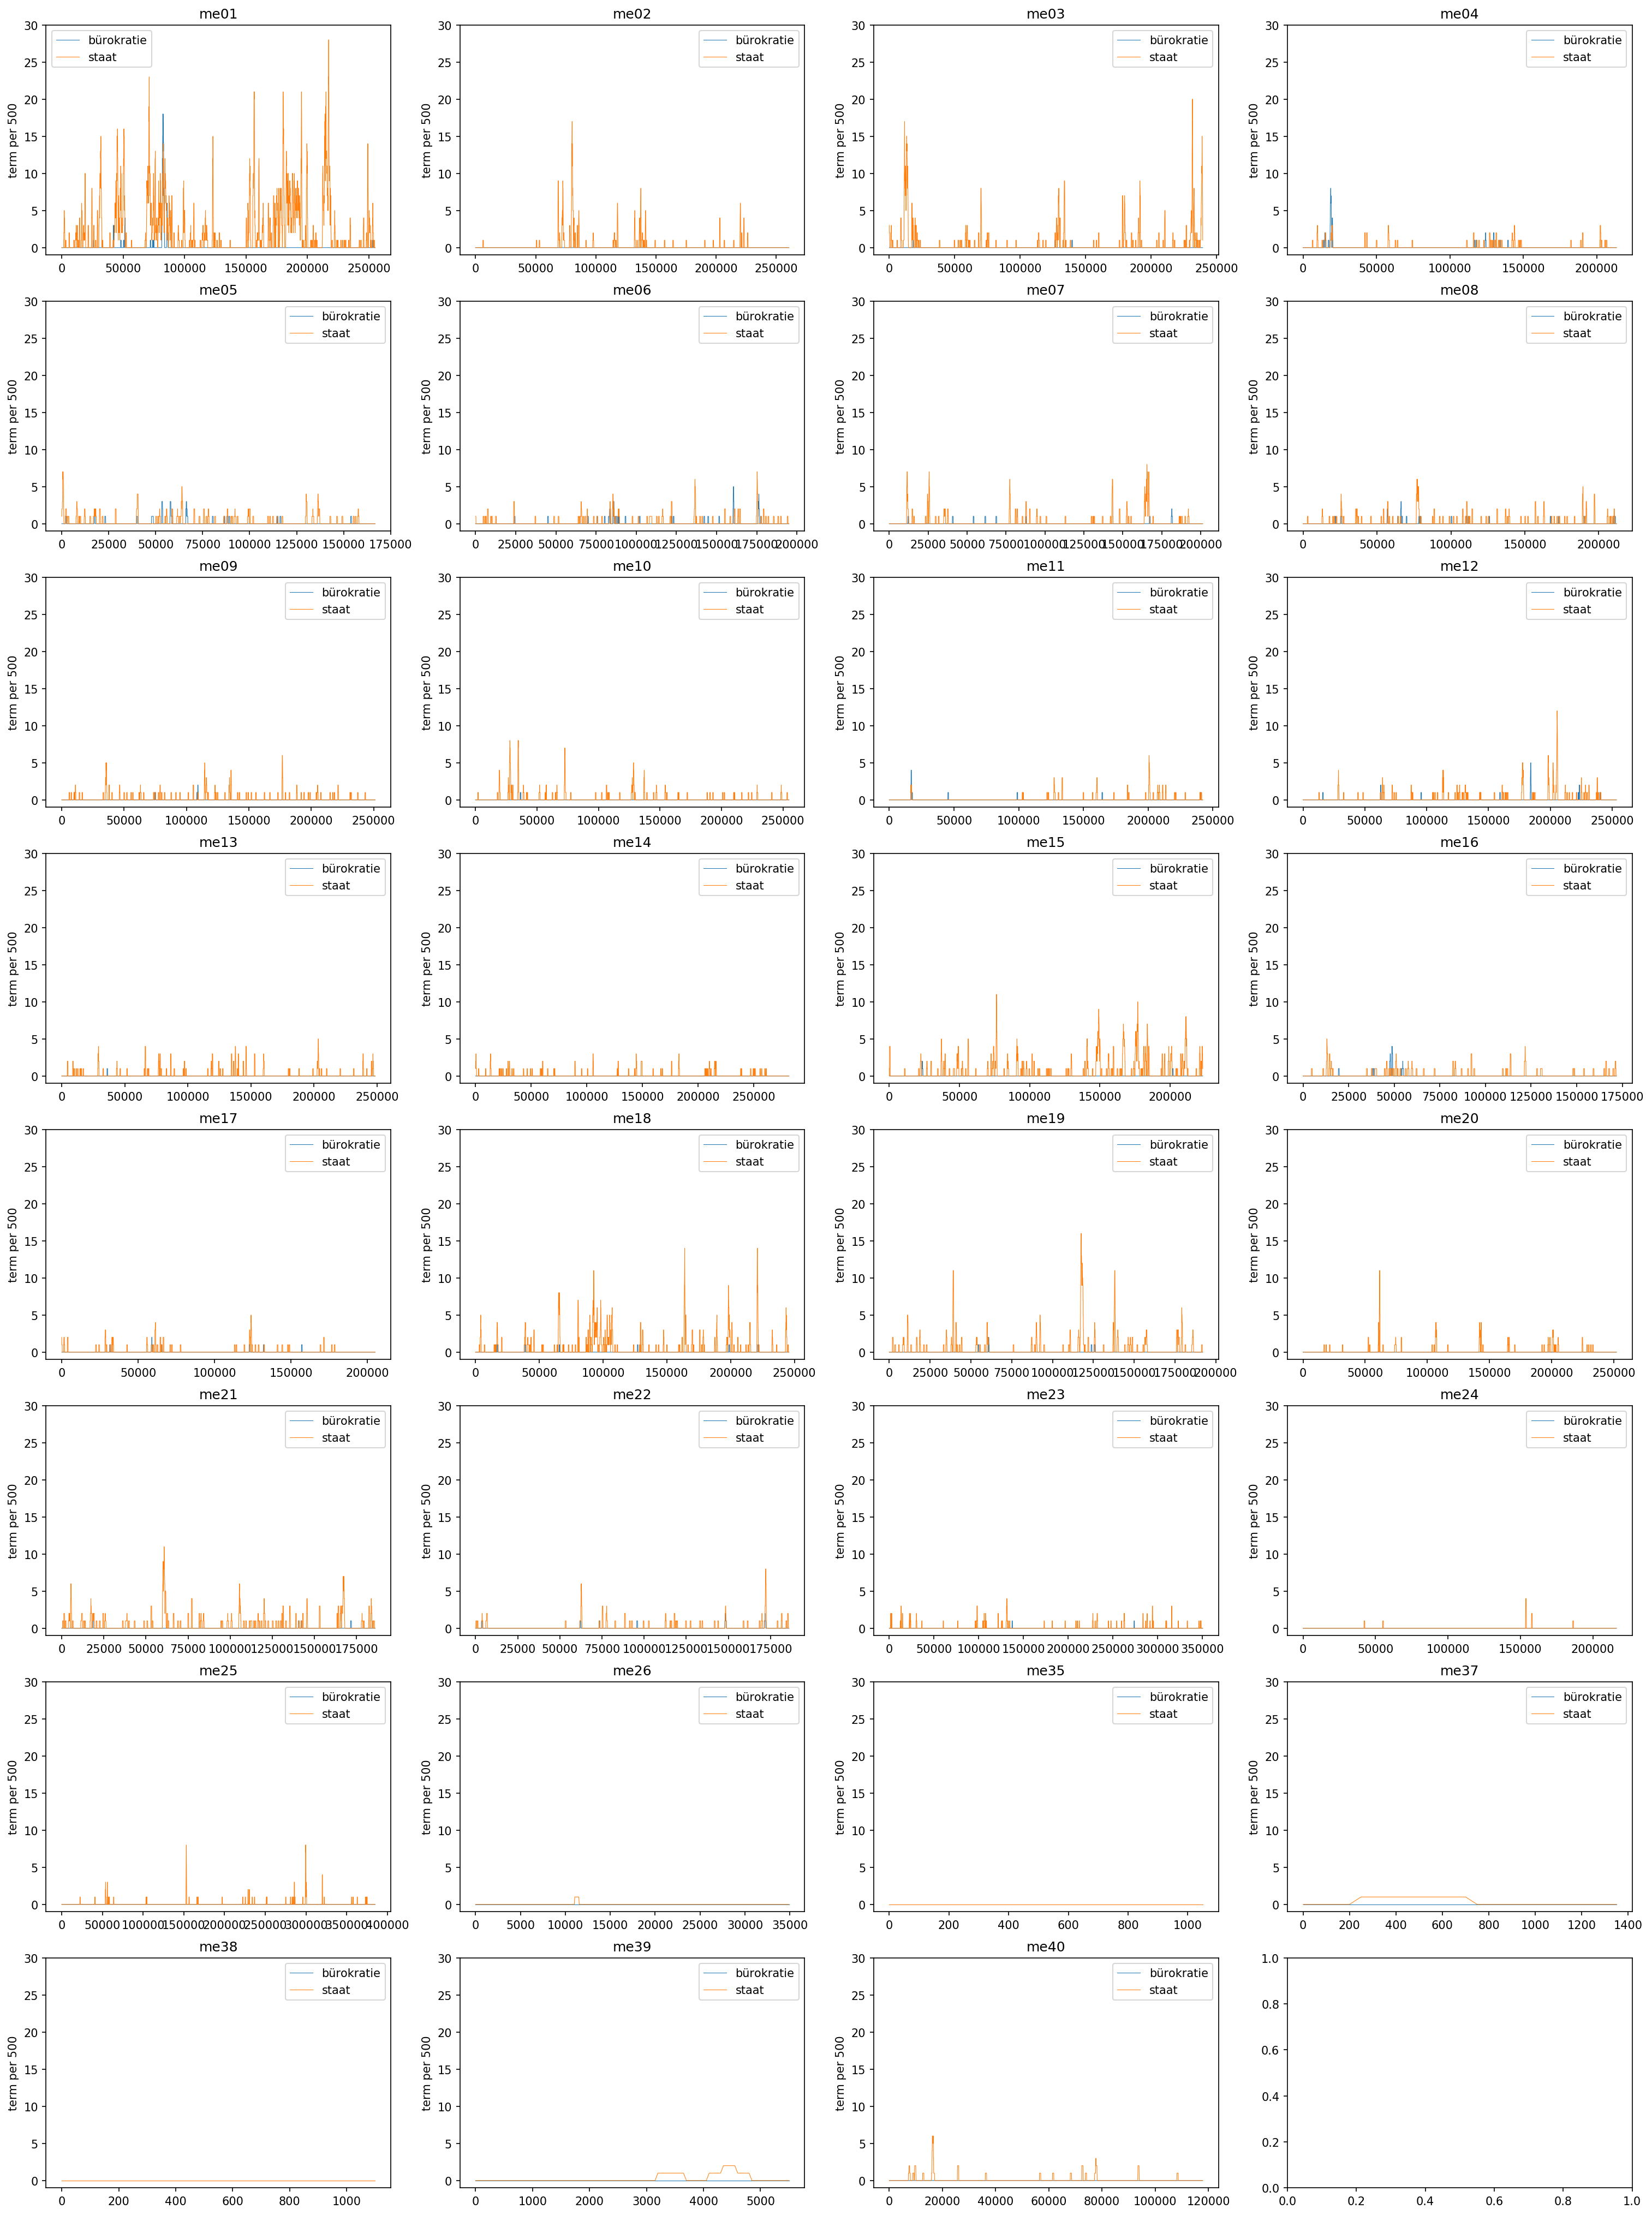

In [26]:
# visualize
fig, axes = plt.subplots(8, 4, figsize=(25, 35), dpi= 150)

for i, work in enumerate(works):
    ax = axes[i//4][i%4]    
    ax.set_ylim(-1,30)
    
    y_values = all_y_values[i]
    x_values = [i*step_size for i in range(len(y_values[0]))]
    
    for i in range(len(y_values)):
        ax.plot(x_values, y_values[i], label=terms[i], linewidth=.5)
    

    ax.legend()
    ax.set_ylabel(f"term per {window_size}")

    ax.set_title(work["work"])
        
plt.savefig(f"figures/termdens_{'_'.join(terms)}.png", format="png")